In [3]:
pip install mlens

Note: you may need to restart the kernel to use updated packages.


'C:\Users\Marini' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr, stats
from imblearn.over_sampling import SMOTE, ADASYN 

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from xgboost import XGBClassifier
from xgboost import plot_importance

from mlens.ensemble import SuperLearner
from mlens.visualization import corrmat 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


%config InlineBackend.figure_format = 'retina'
%matplotlib inline


pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)


[MLENS] backend: threading


In [3]:
df = pd.read_csv('insurance_claims.csv')


In [4]:
df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       17-10-2014           OH   
1                 228   42         342868       27-06-2006           IN   
2                 134   29         687698       06-09-2000           OH   
3                 256   41         227811       25-05-1990           IL   
4                 228   44         367455       06-06-2014           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip insured_sex insured_education_level insured_occupation  \
0       466132        MALE                      MD       craft-repair   
1       468176        MALE                      MD  machine-op-inspct   
2       430632      FEMALE                     PhD              sales   
3       608117      FEMALE                     PhD       armed-forces   
4       610706        MALE               Associate              sales   

  insured_hobbies insured_relationship  capital-gains  capital-loss  \
0        sleeping              husband          53300             0   
1         reading       other-relative              0             0   
2     board-games            own-child          35100             0   
3     board-games            unmarried          48900        -62400   
4     board-games            unmarried          66000        -46000   

  incident_date             incident_type   collision_type incident_severity  \
0    25-01-2015  Single Vehicle Collision   Side Collision      Major Damage   
1    21-01-2015             Vehicle Theft                ?      Minor Damage   
2    22-02-2015   Multi-vehicle Collision   Rear Collision      Minor Damage   
3    10-01-2015  Single Vehicle Collision  Front Collision      Major Damage   
4    17-02-2015             Vehicle Theft                ?      Minor Damage   

  authorities_contacted incident_state incident_city  incident_location  \
0                Police             SC      Columbus     9935 4th Drive   
1                Police             VA     Riverwood       6608 MLK Hwy   
2                Police             NY      Columbus  7121 Francis Lane   
3                Police             OH     Arlington   6956 Maple Drive   
4                  None             NY     Arlington       3041 3rd Ave   

   incident_hour_of_the_day  number_of_vehicles_involved property_damage  \
0                         5                            1             YES   
1                         8                            1               ?   
2                         7                            3              NO   
3                         5                            1               ?   
4                        20                            1              NO   

   bodily_injuries  witnesses police_report_available  total_claim_amount  \
0                1          2                     YES               71610   
1                0          0                       ?                5070   
2                2          3                      NO               34650   
3                1          2                      NO               63400   
4                0          1                      NO                6500   

   injury_claim  property_claim  vehicle_claim  auto_make auto_model  \
0          6510           13020          52080       Saab        92x   
1           780             780           3510   Mercedes       E400   
2          7700            3850          23100      Dodge        RAM   
3          6340            6340          50720  Chevrolet      Tahoe   
4          1300             6

In [5]:
missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)

feature  unique_values  percent_missing  \
0            months_as_customer            391              0.0   
29                    witnesses              4              0.0   
22               incident_state              7              0.0   
23                incident_city              7              0.0   
24            incident_location           1000              0.0   
25     incident_hour_of_the_day             24              0.0   
26  number_of_vehicles_involved              4              0.0   
27              property_damage              3              0.0   
28              bodily_injuries              3              0.0   
30      police_report_available              3              0.0   
20            incident_severity              4              0.0   
31           total_claim_amount            763              0.0   
32                 injury_claim            638              0.0   
33               property_claim            626              0.0   
34                vehicle_claim            726              0.0   
35                    auto_make             14              0.0   
36                   auto_model             39              0.0   
37                    auto_year             21              0.0   
21        authorities_contacted              5              0.0   
19               collision_type              4              0.0   
1                           age             46              0.0   
9                   insured_zip            995              0.0   
2                 policy_number           1000              0.0   
3              policy_bind_date            951              0.0   
4                  policy_state              3              0.0   
5                    policy_csl              3              0.0   
6             policy_deductable              3              0.0   
7         policy_annual_premium            991              0.0   
8                umbrella_limit             11              0.0   
10                  insured_sex              2              0.0   
18                incident_type              4              0.0   
11      insured_education_level              7              0.0   
12           insured_occupation             14              0.0   
13              insured_hobbies             20              0.0   
14         insured_relationship              6              0.0   
15                capital-gains            338              0.0   
16                 capital-loss            354              0.0   
17                incident_date             60              0.0   
38               fraud_reported              2              0.0   

    percent_biggest_cat     type  
0                   0.8    int64  
29                 25.8    int64  
22                 26.2   object  
23                 15.7   object  
24                  0.1   object  
25                  5.4    int64  
26                 58.1    int64  
27                 36.0   object  
28                 34.0    int64  
30                 34.3   object  
20                 35.4   object  
31                  0.5    int64  
32                  2.5    int64  
33                  1.9    int64  
34                  0.7    int64  
35                  8.0   object  
36                  4.3   object  
37                  5.6    int64  
21                 29.2   object  
19                 29.2   object  
1                   4.9    int64  
9                   0.2    int64  
2                   0.1    int64  
3                   0.3   object  
4                  35.2   object  
5                  35.1   object  
6                  35.1    int64  
7                   0.2  float64  
8                  79.8    int64  
10                 53.7   object  
18                 41.9   object  
11                 16.1   object  
12                  9.3   object  
13                  6.4   object  
14                 18.3   object  
15                 50.8    int64  
16                 47.5    int64  
17           

In [6]:
df.describe()

months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min               433.330000   -1.000000e+06  430104.000000       0.000000   
25%              1089.607500    0.000000e+00  448404.500000       0.000000   
50%              1257.200000    0.000000e+00  466445.500000       0.000000   
75%              1415.695000    0.000000e+00  603251.000000   51025.000000   
max              2047.590000    1.000000e+07  620962.000000  100500.000000   

        capital-loss  incident_hour_of_the_day  number_of_vehicles_involved  \
count    1000.000000               1000.000000                   1000.00000   
mean   -26793.700000                 11.644000                      1.83900   
std     28104.096686                  6.951373                      1.01888   
min   -111100.000000                  0.000000                      1.00000   
25%    -51500.000000                  6.000000                      1.00000   
50%    -23250.000000                 12.000000                      1.00000   
75%         0.000000                 17.000000                      3.00000   
max         0.000000                 23.000000                      4.00000   

       bodily_injuries    witnesses  total_claim_amount  injury_claim  \
count      1000.000000  1000.000000          1000.00000   1000.000000   
mean          0.992000     1.487000         52761.94000   7433.420000   
std           0.820127     1.111335         26401.53319   4880.951853   
min           0.000000     0.000000           100.00000      0.000000   
25%           0.000000     1.000000         41812.50000   4295.000000   
50%           1.000000     1.000000         58055.00000   6775.000000   
75%           2.000000     2.000000         70592.50000  11305.000000   
max           2.000000     3.000000        114920.00000  21450.000000   

       property_claim  vehicle_claim    auto_year  
count     1000.000000    1000.000000  1000.000000  
mean      7399.570000   37928.950000  2005.103000  
std       4824.726179   18886.252893     6.015861  
min          0.000000      70.000000  1995.000000  
25%       4445.000000   30292.500000  2000.000000  
50%       6750.000000   42100.000000  2005.000000  
75%      10885.000000   50822.500000  2010.000000  
max      23670.000000   79560.000000  2015.000000

In [7]:
#extract out the year
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['policy_bind_year']=df['policy_bind_date'].dt.year

In [8]:

#extract the month out 
#all accidents are from 2015 jan and feb, so year isnt very important
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['incident_month']=df['incident_date'].dt.month

In [9]:

#replace "?" with undocumented 

df['collision_type'] = df['collision_type'].replace("?", "undocumented")
df['police_report_available'] = df['police_report_available'].replace("?", "undocumented")
df['property_damage'] = df['property_damage'].replace("?", "undocumented")
df['auto_make'] = df['auto_make'].replace("Suburu", "Subaru")

In [10]:
#incident_severity can be seen as ordinal
#code them in order of severity 

df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":0,
                                                       "Minor Damage":1,
                                                       "Major Damage":2,
                                                       "Total Loss":3
                                                      }).astype("int32")
df.incident_severity.value_counts()

1    354
3    280
2    276
0     90
Name: incident_severity, dtype: int64

In [11]:
#umbrella limit is like an insruance topup that pays your liabilities in case you get sued
#cannot be zero
#this 0 is an error

df['umbrella_limit'].sort_values(ascending=True)

290    -1000000
0             0
623           0
624           0
625           0
         ...   
657     9000000
458     9000000
975     9000000
430    10000000
115    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [12]:
#edit to positve
df['umbrella_limit'].iloc[290] = 1000000

C:\Users\Marini Raju\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
#check
df['umbrella_limit'].sort_values(ascending=True)

0             0
622           0
623           0
624           0
625           0
         ...   
700     9000000
88      9000000
975     9000000
115    10000000
430    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [14]:
all_var = list(df.columns)
len(all_var)

41

In [15]:
cont_var =['age','incident_hour_of_the_day',
           'number_of_vehicles_involved','total_claim_amount',
           'injury_claim','property_claim','vehicle_claim',
           'months_as_customer','policy_annual_premium','policy_deductable',
           'umbrella_limit','capital-gains','capital-loss', 
           'auto_year','witnesses','bodily_injuries','policy_bind_year','incident_severity']

len(cont_var)

18

In [16]:
#ordinal var

ord_var = ['policy_deductable','witnesses','bodily_injuries','incident_severity']
len(ord_var)

4

In [17]:
#quan var = interval or ratio 

quan_var = (list(set(cont_var) - set(ord_var))) 
len(quan_var)

14

In [18]:
nom_var = (list(set(all_var) - set(cont_var))) 
len(nom_var)

23

In [19]:
nom_var

['incident_location',
 'fraud_reported',
 'police_report_available',
 'authorities_contacted',
 'incident_state',
 'auto_model',
 'insured_zip',
 'auto_make',
 'policy_state',
 'insured_sex',
 'insured_relationship',
 'insured_education_level',
 'collision_type',
 'property_damage',
 'policy_number',
 'policy_csl',
 'incident_date',
 'incident_month',
 'policy_bind_date',
 'incident_type',
 'insured_occupation',
 'insured_hobbies',
 'incident_city']

In [20]:
#check for norminal data with vevry large number of categories

for col in nom_var:
    print("###", col, "###" )
    print("  ")
    print(df[col].value_counts())
    print("---------------------------------------------")
    print("  ")


### incident_location ###
  
1220 MLK Ave           1
4835 Britain Ridge     1
3796 Cherokee Drive    1
6888 Elm Ridge         1
7783 Lincoln Hwy       1
                      ..
5053 Tree Drive        1
4577 Sky Hwy           1
5650 Sky Drive         1
2787 MLK St            1
3770 Flute Drive       1
Name: incident_location, Length: 1000, dtype: int64
---------------------------------------------
  
### fraud_reported ###
  
N    753
Y    247
Name: fraud_reported, dtype: int64
---------------------------------------------
  
### police_report_available ###
  
undocumented    343
NO              343
YES             314
Name: police_report_available, dtype: int64
---------------------------------------------
  
### authorities_contacted ###
  
Police       292
Fire         223
Other        198
Ambulance    196
None          91
Name: authorities_contacted, dtype: int64
---------------------------------------------
  
### incident_state ###
  
NY    262
SC    248
WV    217
VA    110
NC  

In [21]:
#for those that have not too many unique, we can plot them out

large_cat = []

for col in nom_var:
    if df[col].nunique() > 20:
        large_cat.append(col)
        print(col, df[col].nunique())
    else: 
        pass
    
#incident location, insured zip, policy bind date, policy number too many unique to be meaningful

incident_location 1000
auto_model 39
insured_zip 995
policy_number 1000
incident_date 60
policy_bind_date 951


In [22]:
#get a data frame with var that have large num categories
#only auto model 
large_dummy = pd.get_dummies(df[['auto_model','incident_date']], drop_first=True)

#put in the DV
large_dummy['fraud_reported']=df['fraud_reported']

#numerical code the DV
large_dummy['fraud_reported'] = large_dummy['fraud_reported'].map({"Y":1,"N":0})

#unique to each case. wont be useful
large_dummy.head(10)

incident_date  auto_model_92x  auto_model_93  auto_model_95  auto_model_A3  \
0    2015-01-25               1              0              0              0   
1    2015-01-21               0              0              0              0   
2    2015-02-22               0              0              0              0   
3    2015-10-01               0              0              0              0   
4    2015-02-17               0              0              0              0   
5    2015-02-01               0              0              1              0   
6    2015-01-13               0              0              0              0   
7    2015-02-27               0              0              0              0   
8    2015-01-30               0              0              0              0   
9    2015-05-01               1              0              0              0   

   auto_model_A5  auto_model_Accord  auto_model_C300  auto_model_CRV  \
0              0                  0                0               0   
1              0                  0                0               0   
2              0                  0                0               0   
3              0                  0                0               0   
4              0                  0                0               0   
5              0                  0                0               0   
6              0                  0                0               0   
7              1                  0                0               0   
8              0                  0                0               0   
9              0                  0                0               0   

   auto_model_Camry  auto_model_Civic  auto_model_Corolla  auto_model_E400  \
0                 0                 0                   0                0   
1                 0                 0                   0                1   
2                 0                 0                   0                0   
3                 0                 0                   0                0   
4                 0                 0                   0                0   
5                 0                 0                   0                0   
6                 0                 0                   0                0   
7                 0                 0                   0                0   
8                 1                 0                   0                0   
9                 0                 0                   0                0   

   auto_model_Escape  auto_model_F150  auto_model_Forrestor  \
0                  0                0                     0   
1                  0                0                     0   
2                  0                0                     0   
3                  0                0                     0   
4                  0                0                     0   
5                  0                0                     0   
6                  0                0                     0   
7                  0                0                     0   
8                  0                0                     0   
9                  0                0                     0   

   auto_model_Fusion  auto_model_Grand Cherokee  auto_model_Highlander  \
0                  0                          0                      0   
1                  0                          0                      0   
2                  0                          0                      0   
3                  0                          0                      0   
4                  0                          0                      0   
5                  0                          0                      0   
6                  0                          0                      0   
7                  0                          0                      0   
8                  0                          0                      0   
9                  0               

In [23]:
#Color negative numbers red, positive blue
def color(val):
    color = 'green' if val == 1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = large_dummy.corr()
corr.style.applymap(color)


#no correlation with make and fraud. drop var

In [24]:
#drop this variables from analysis 

df.drop(large_cat, axis=1, inplace=True)

In [25]:
#redefine the norminal var
#remove dv from the list

nom_var.remove('fraud_reported')
nom_var = (list(set(nom_var) - set(large_cat))) 
len(nom_var)

16

In [26]:
nom_var

['policy_state',
 'collision_type',
 'property_damage',
 'insured_sex',
 'insured_relationship',
 'policy_csl',
 'police_report_available',
 'incident_type',
 'authorities_contacted',
 'incident_month',
 'insured_occupation',
 'incident_state',
 'insured_hobbies',
 'auto_make',
 'insured_education_level',
 'incident_city']

In [27]:
#count each level of the Dv

df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

In [28]:
#proportion of each level of DV

df.fraud_reported.value_counts(normalize=True)

N    0.753
Y    0.247
Name: fraud_reported, dtype: float64

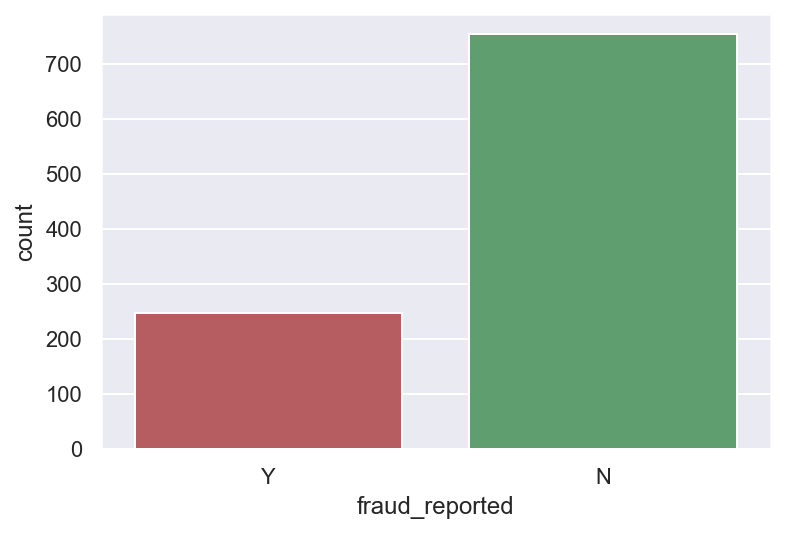

In [29]:
#dist of dv
#plt.style.use('dark_background') for ppt 
sns.set()

sns.countplot(x ="fraud_reported", data=df, palette=['r','g']);

In [30]:

#Color negative numbers red

def color(val):
    color = 'green' if val ==1 else 'red' if val < -0.3 else 'blue' if val > 0.3 else 'black'   #write like lambda
    return 'color: %s' % color


corr = df[cont_var].corr()
corr.style.applymap(color)

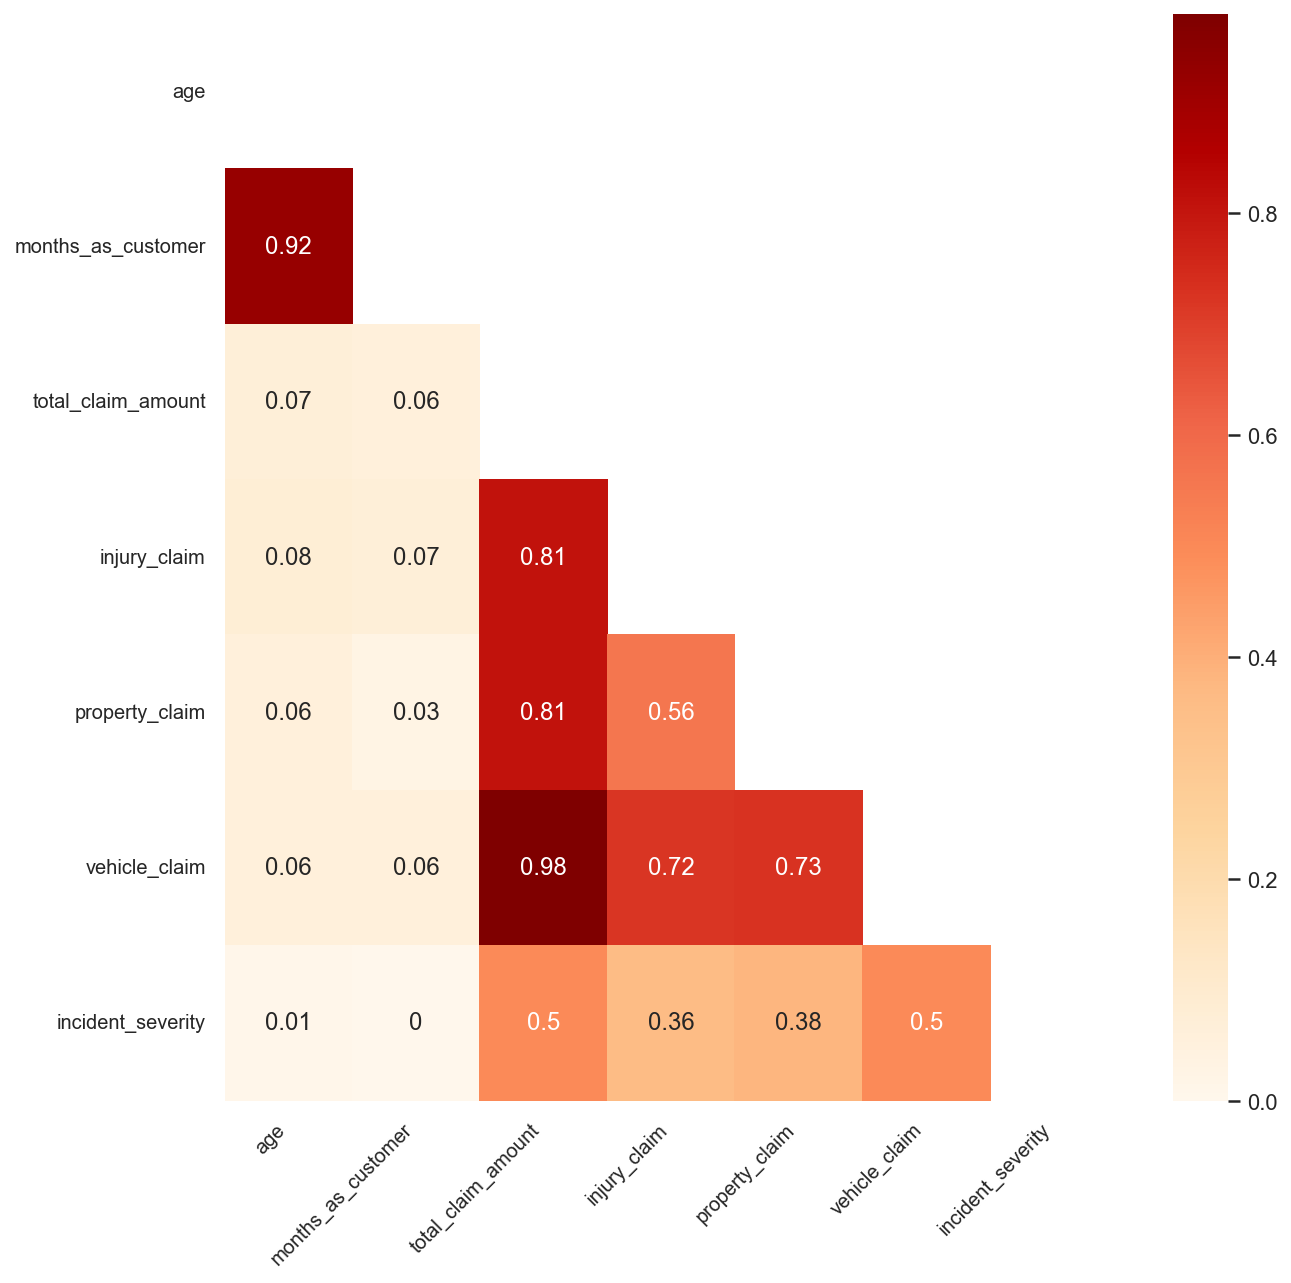

In [31]:
sns.set_style('white')

# heatmap from those with at least 0.3 magnitude in corr, includeing the DV
corr_list=['age','months_as_customer','total_claim_amount',
           'injury_claim', 'property_claim','vehicle_claim',
           'incident_severity','fraud_reported']

corr_df = df[corr_list]
corr=round(corr_df.corr(),2)

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  #triu triangle upper

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap='OrRd')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha= 'right', rotation=45 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

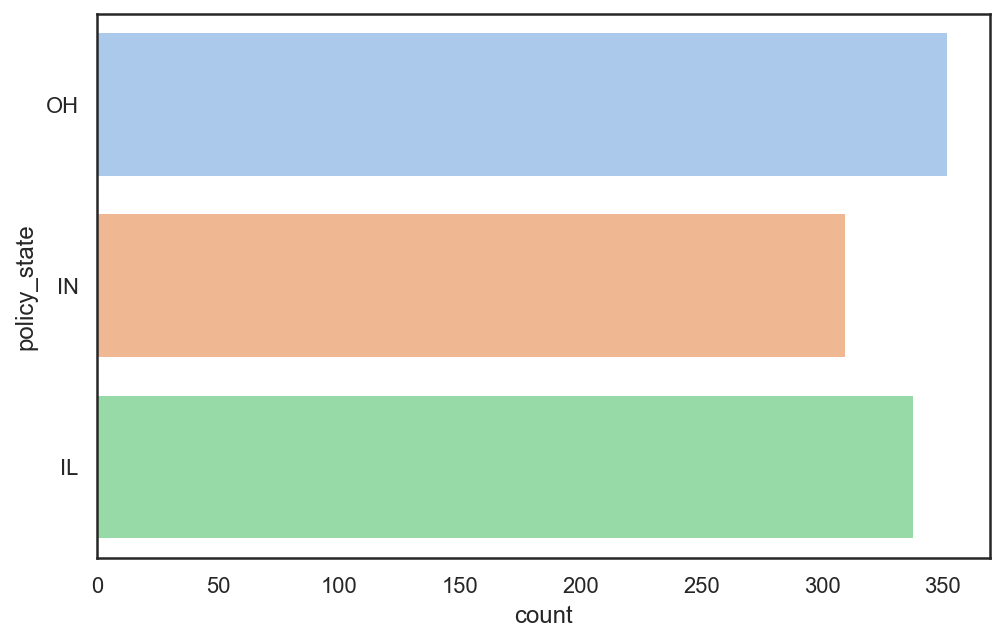

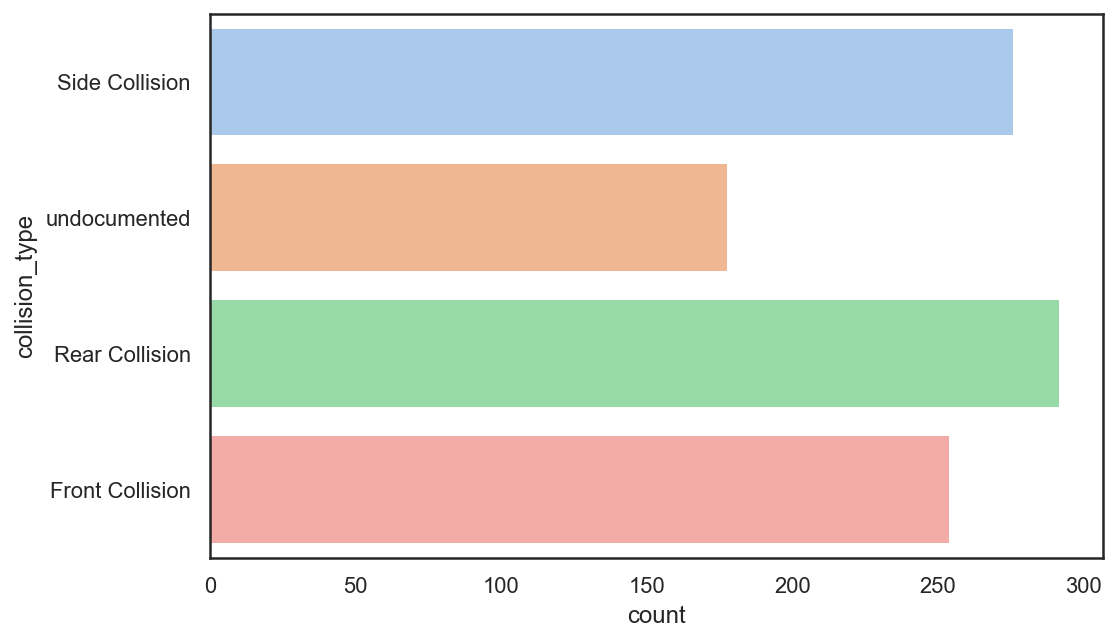

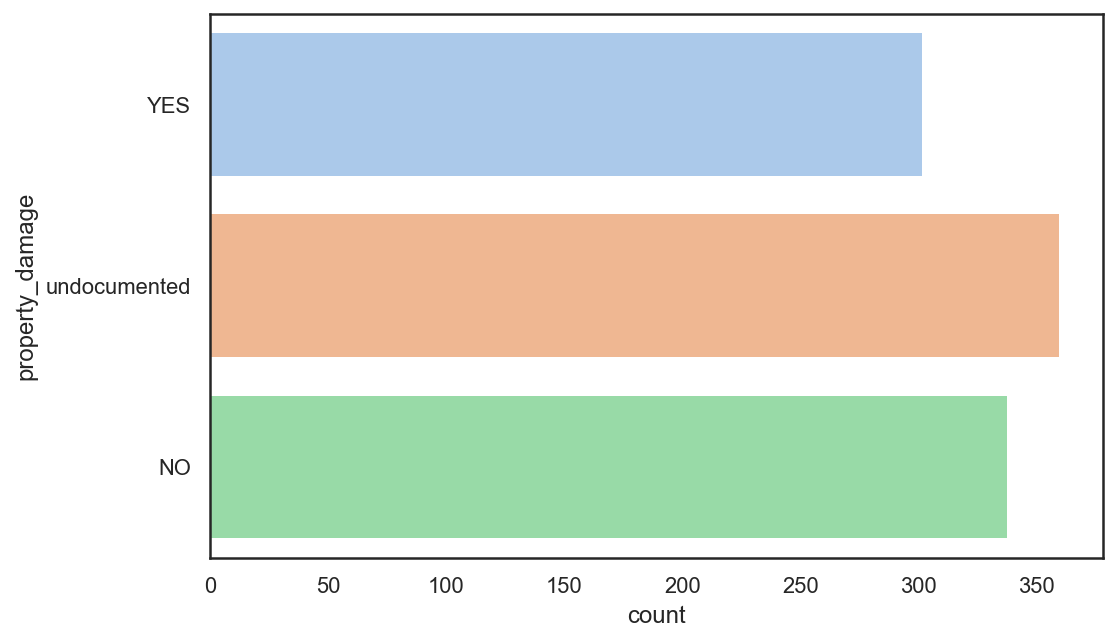

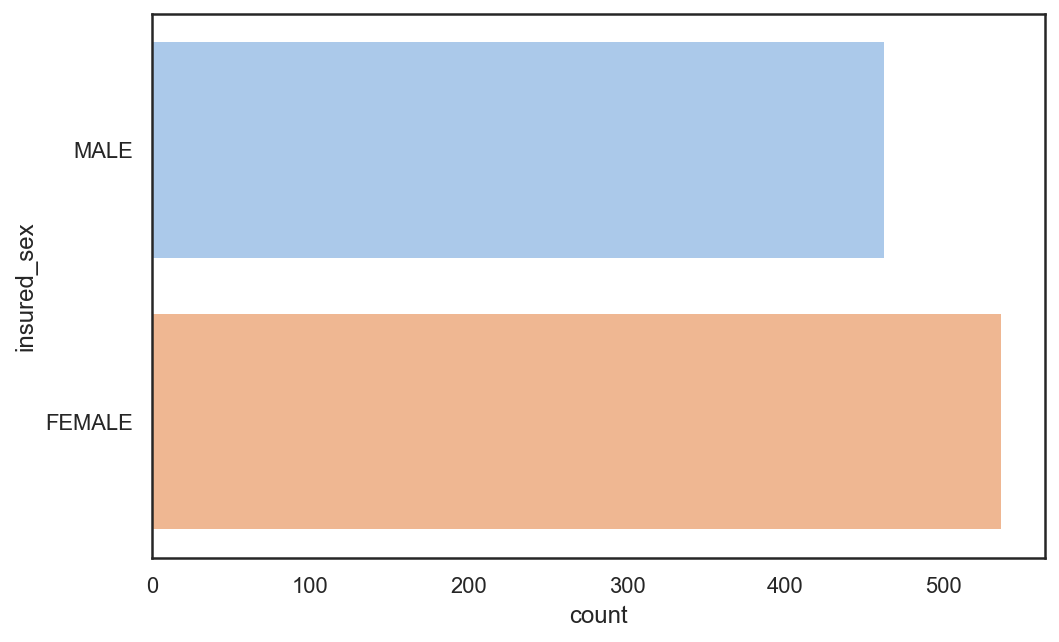

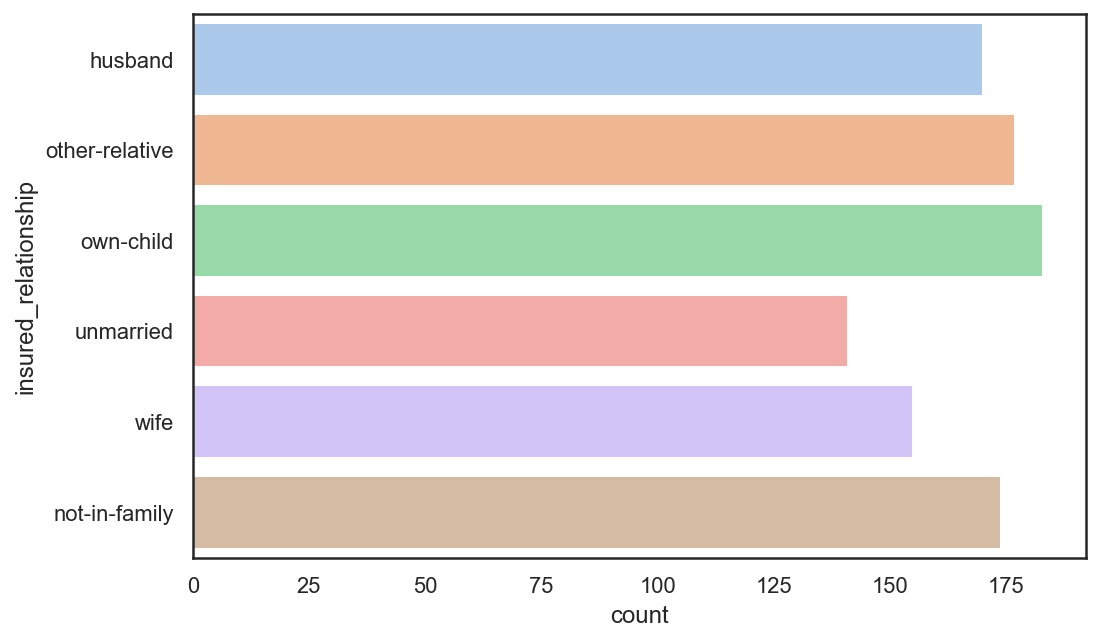

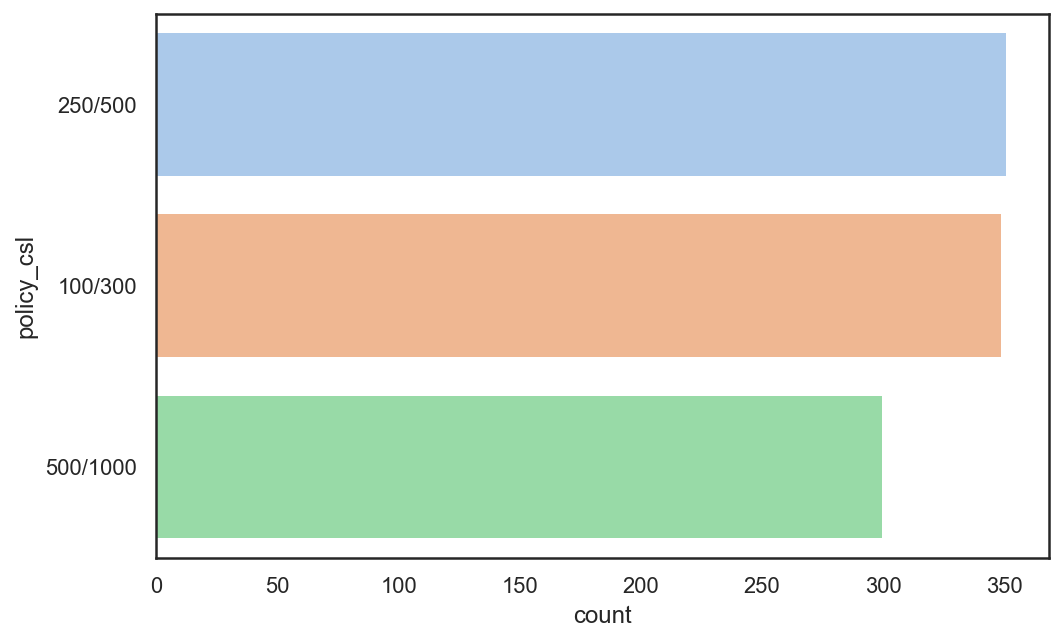

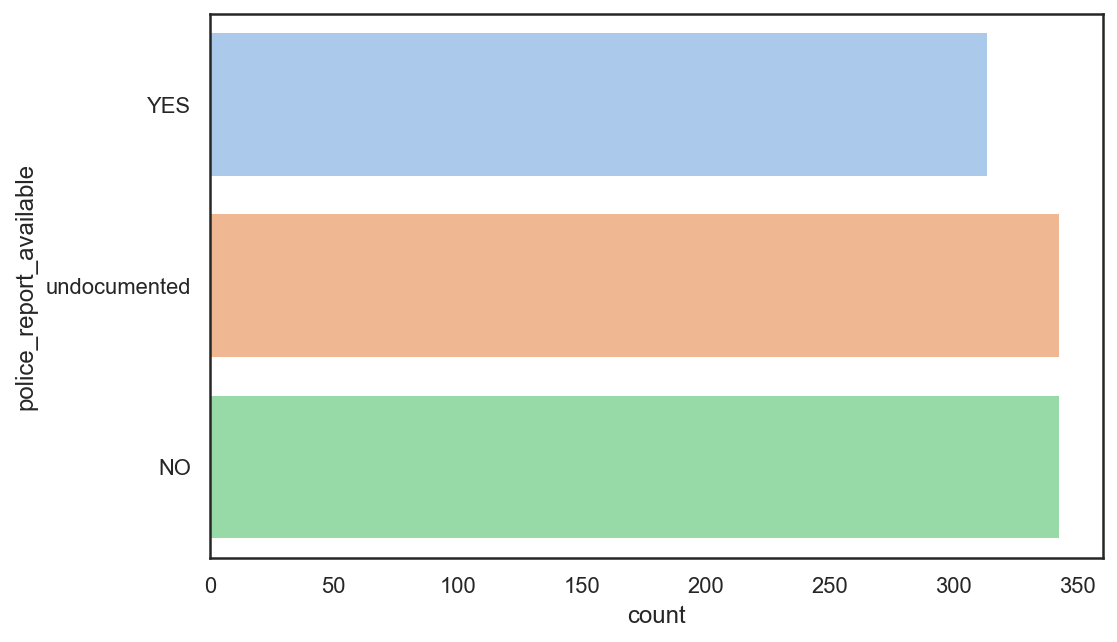

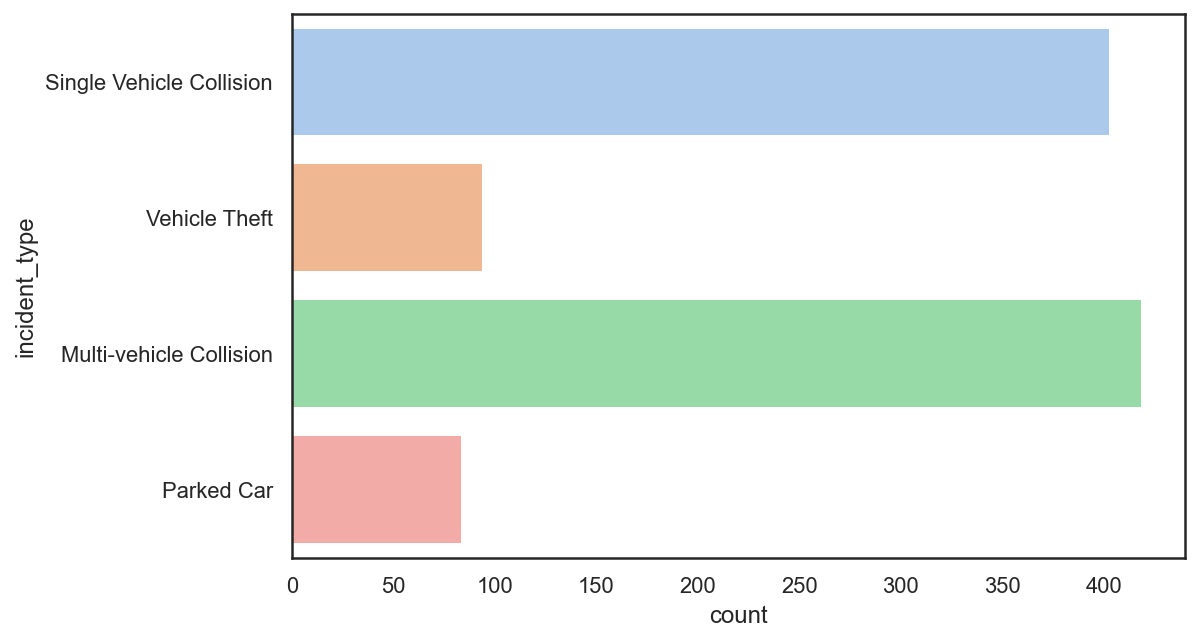

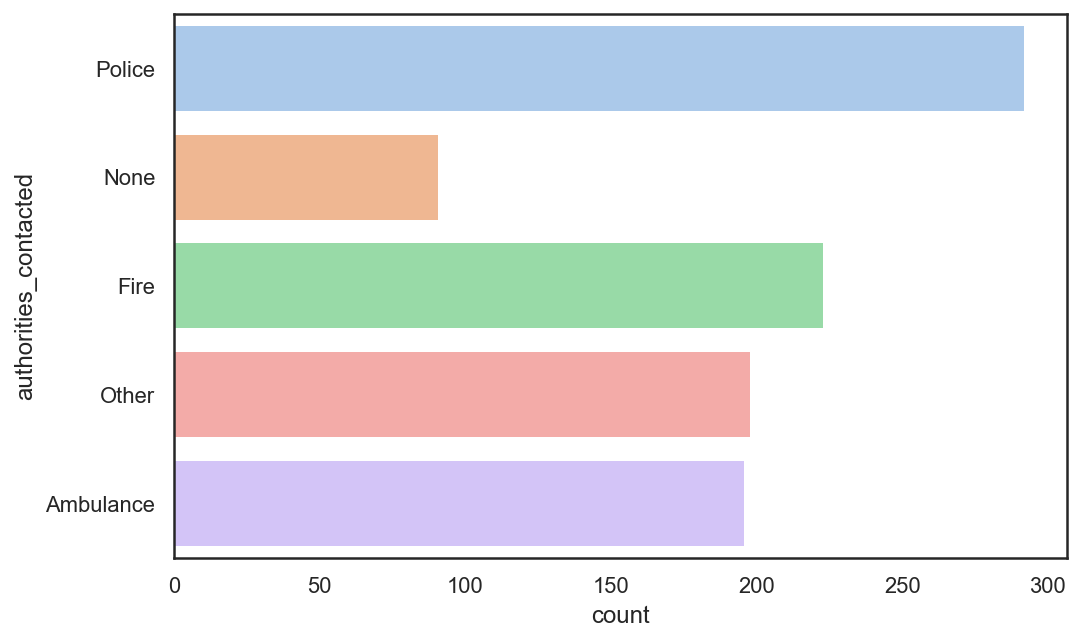

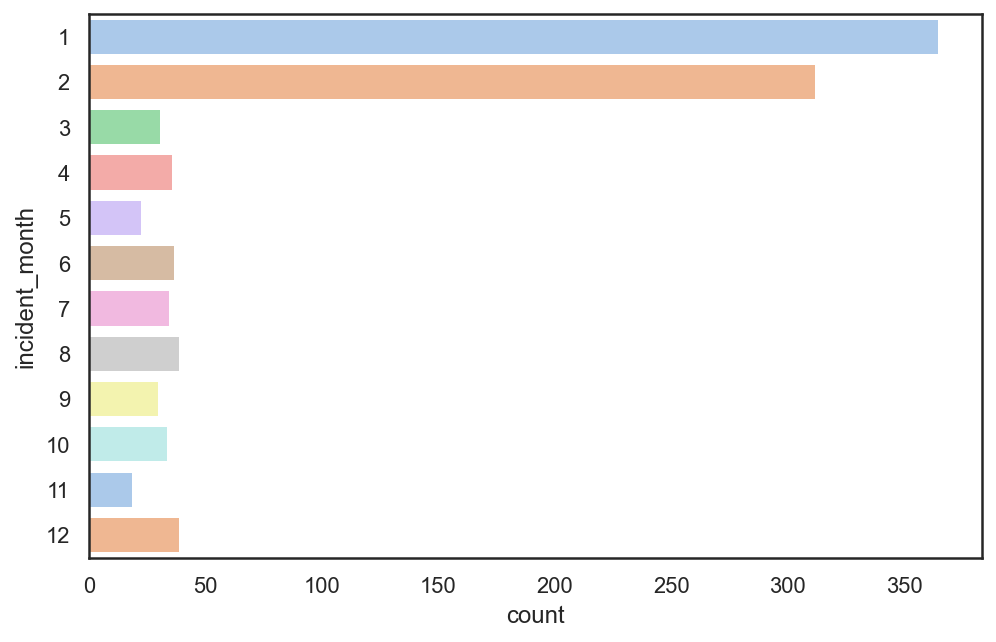

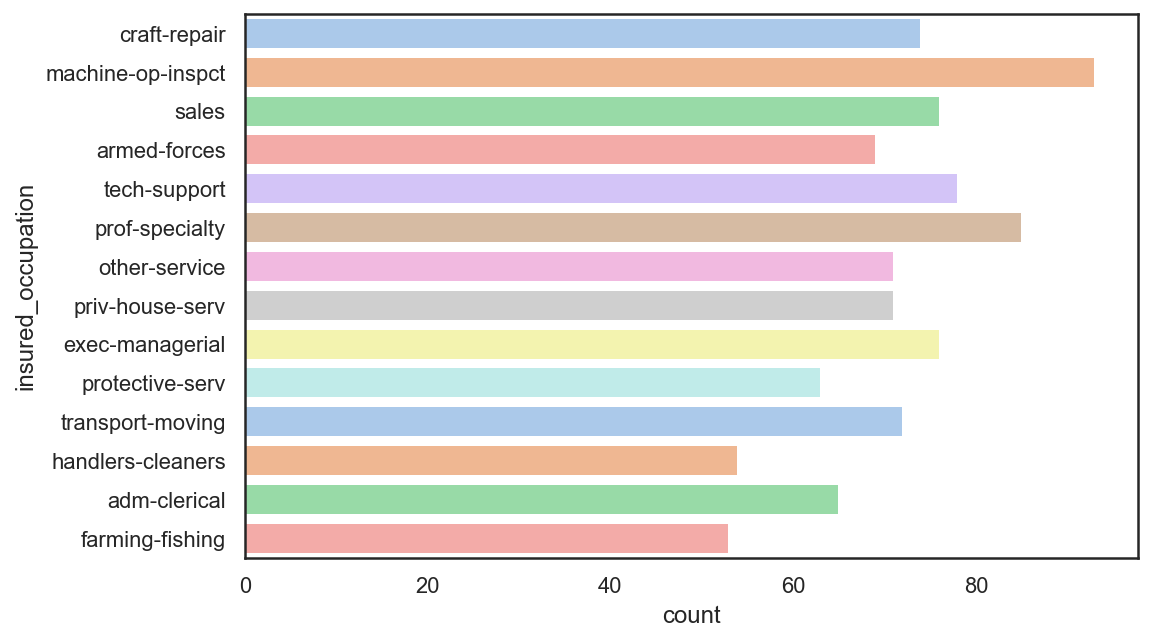

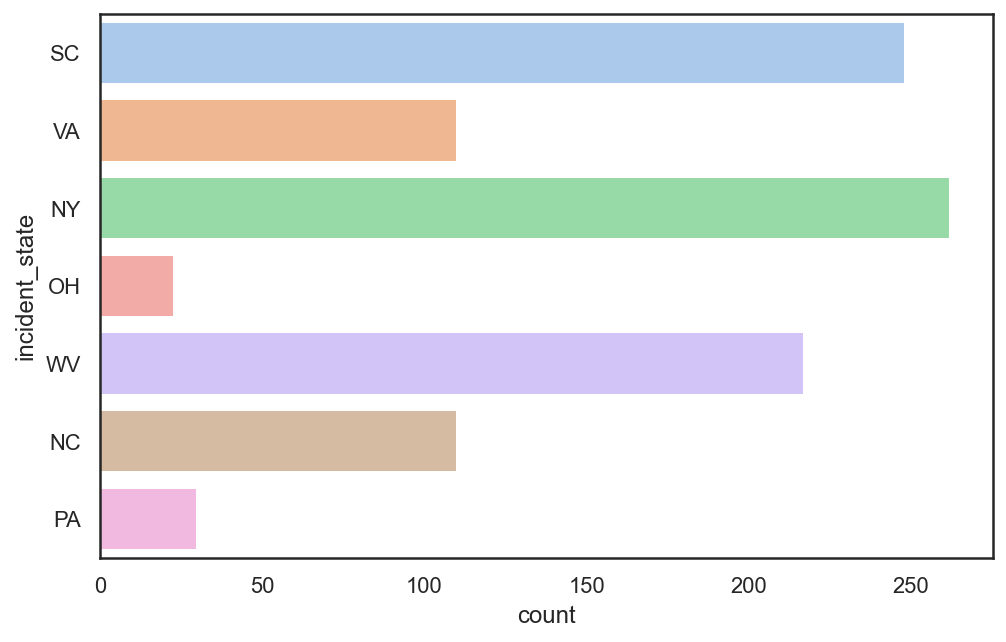

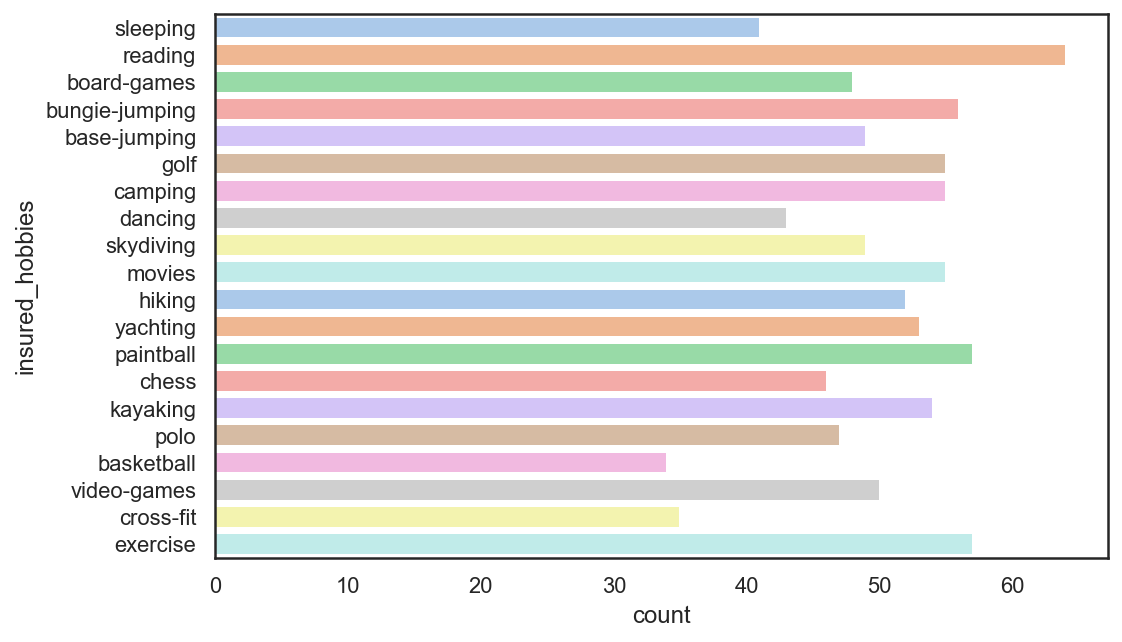

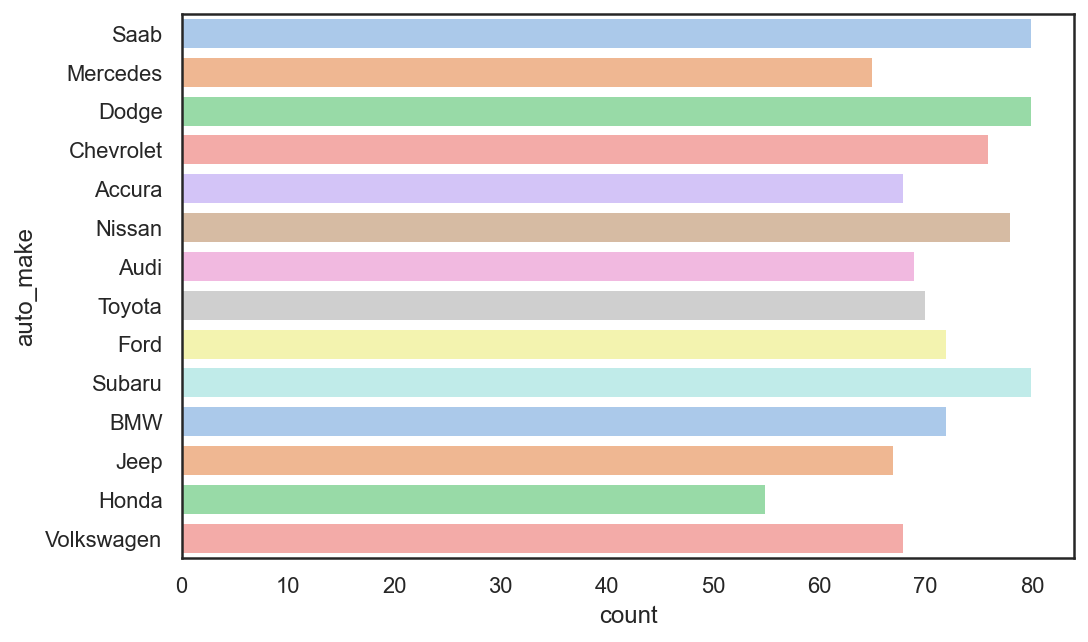

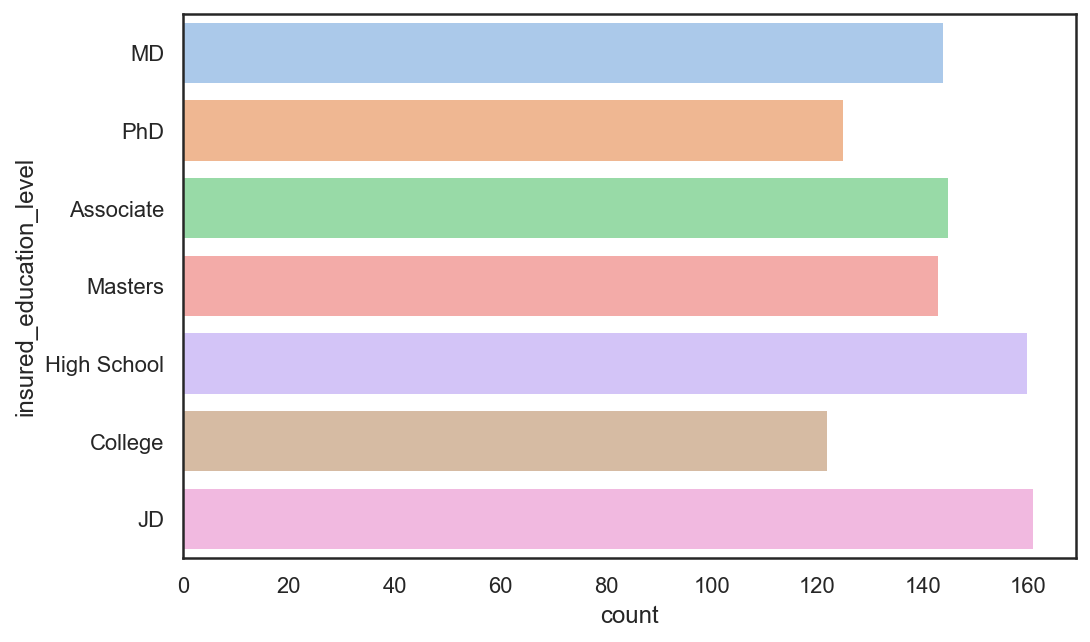

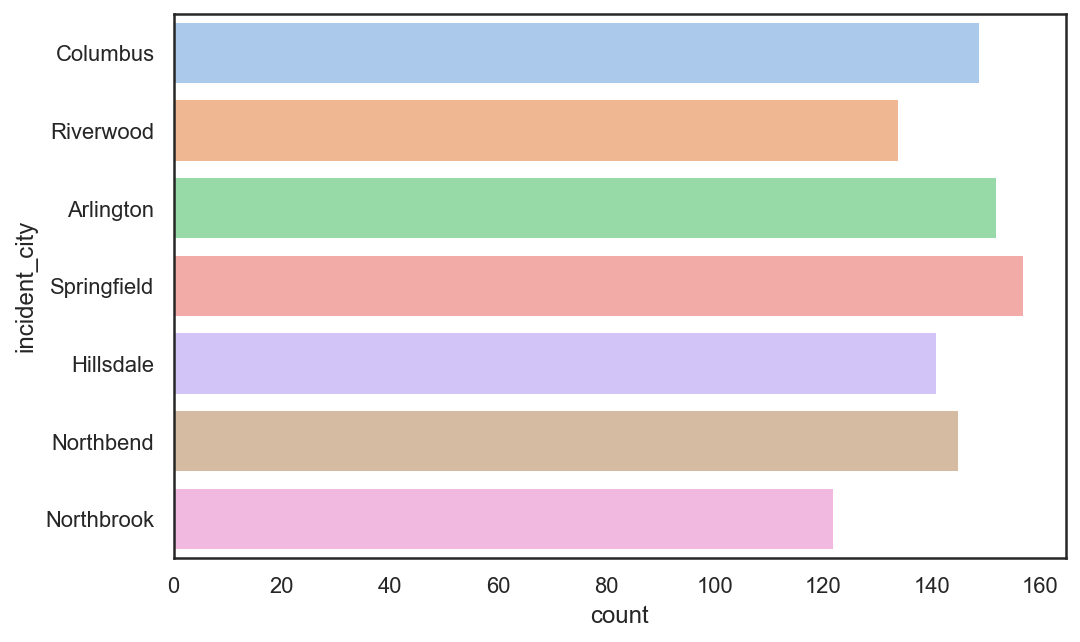

In [35]:
#countplot of discrete var , 

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(8,5))
    sns.countplot(y=name, data=df, palette="pastel")

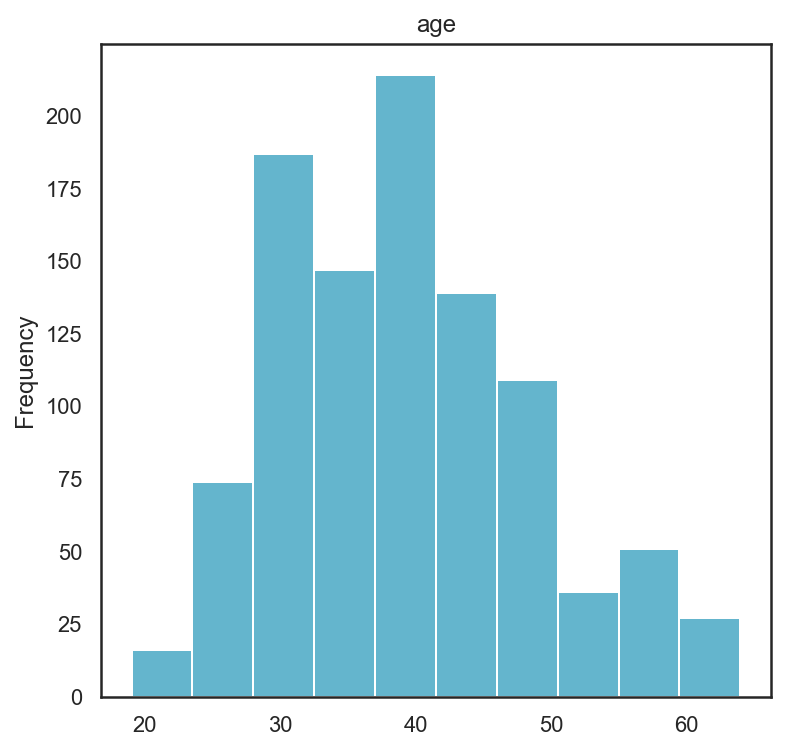

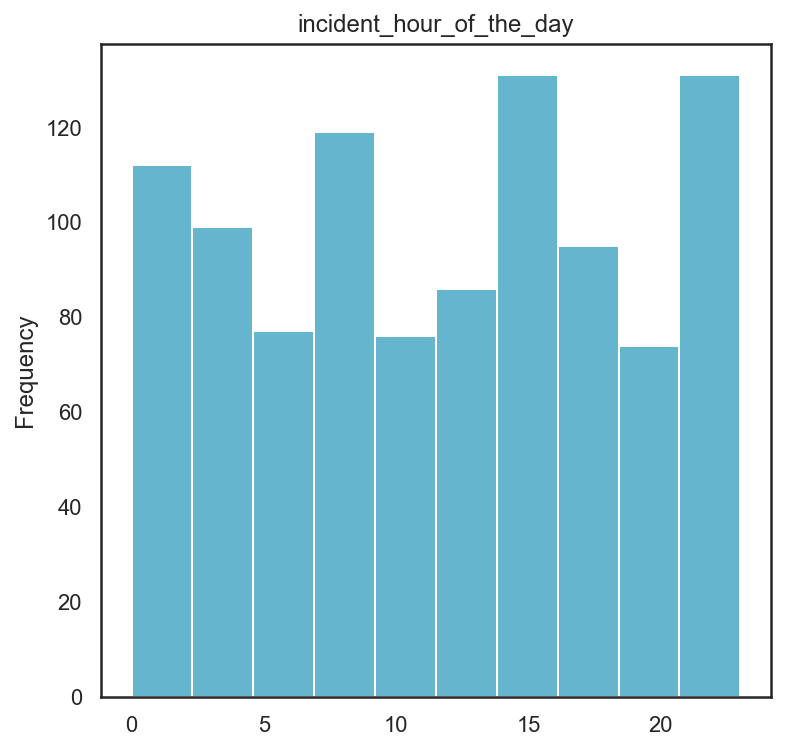

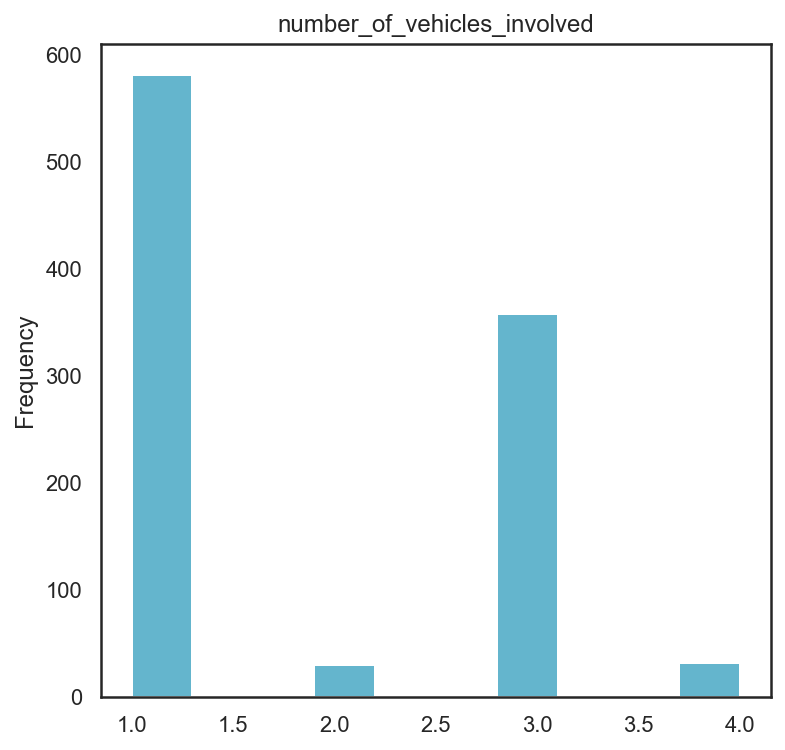

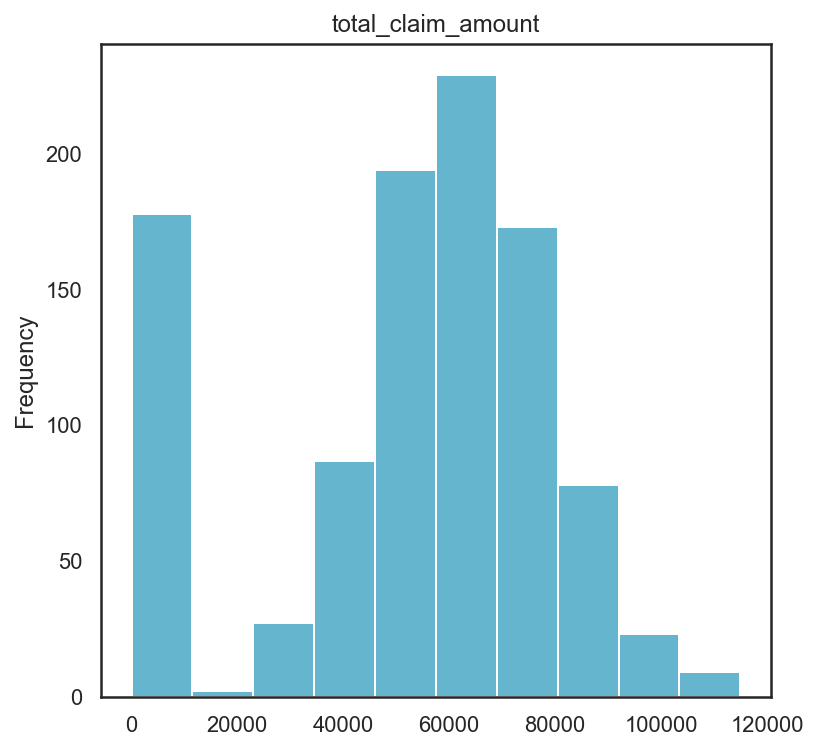

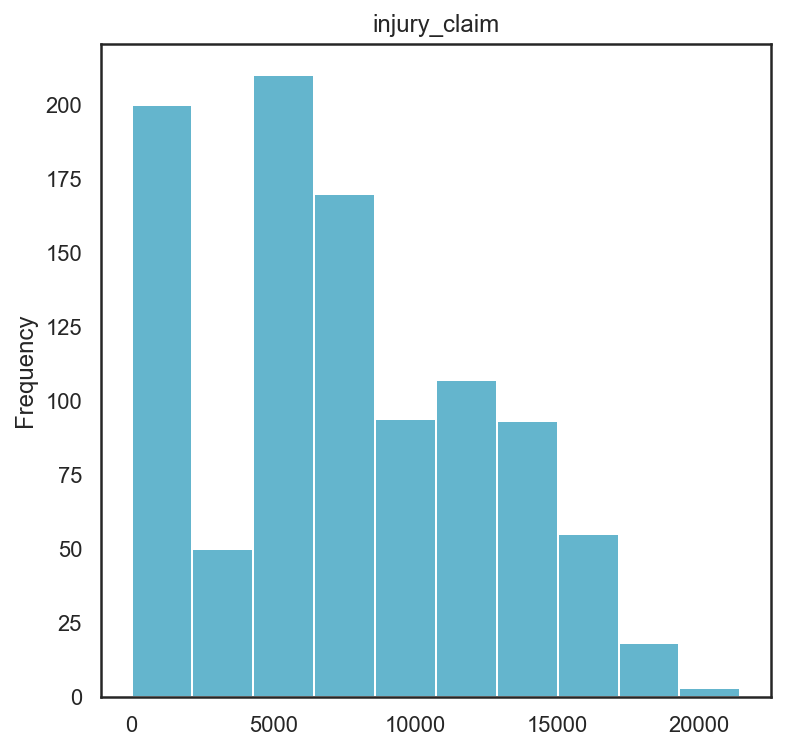

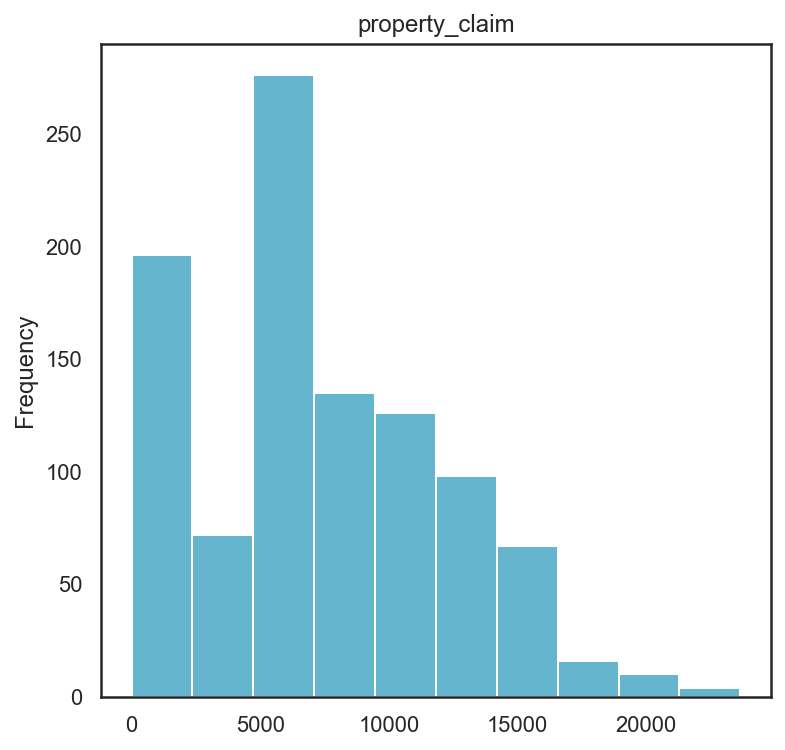

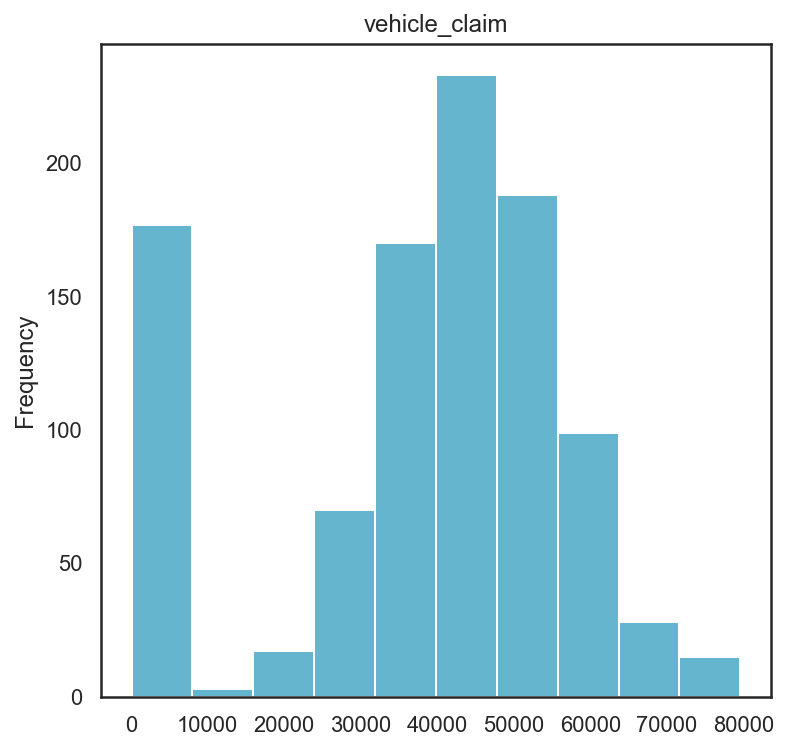

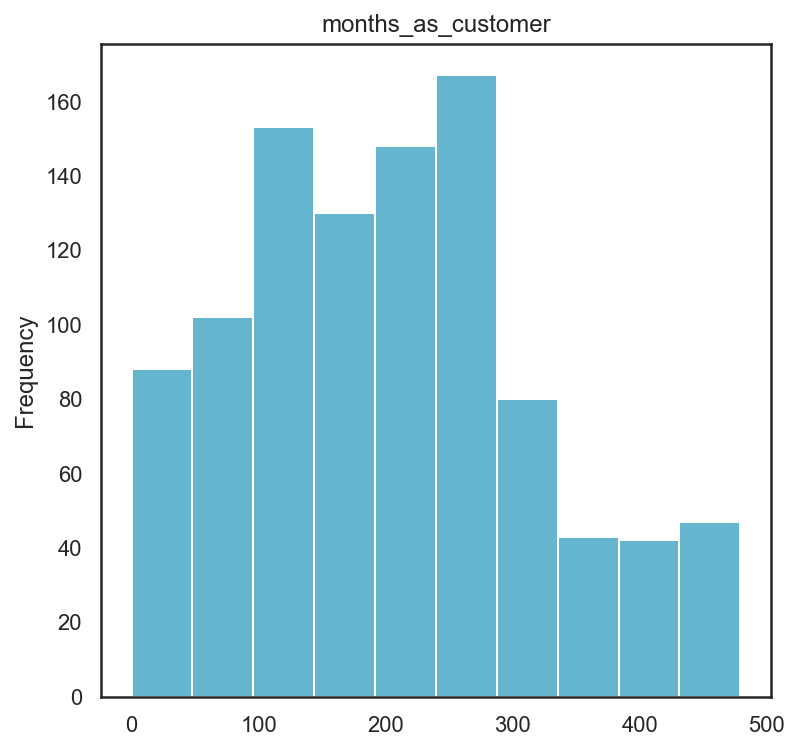

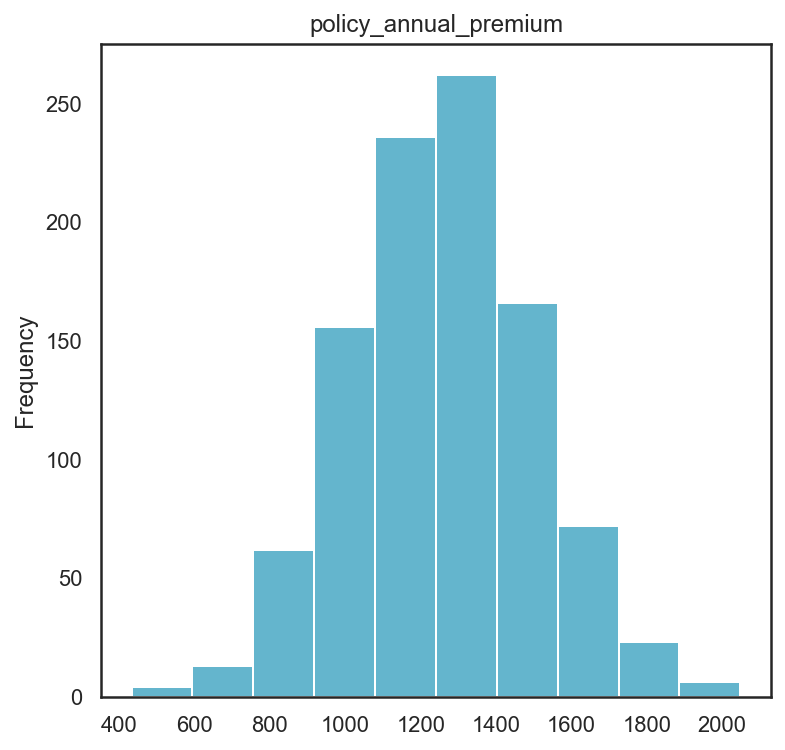

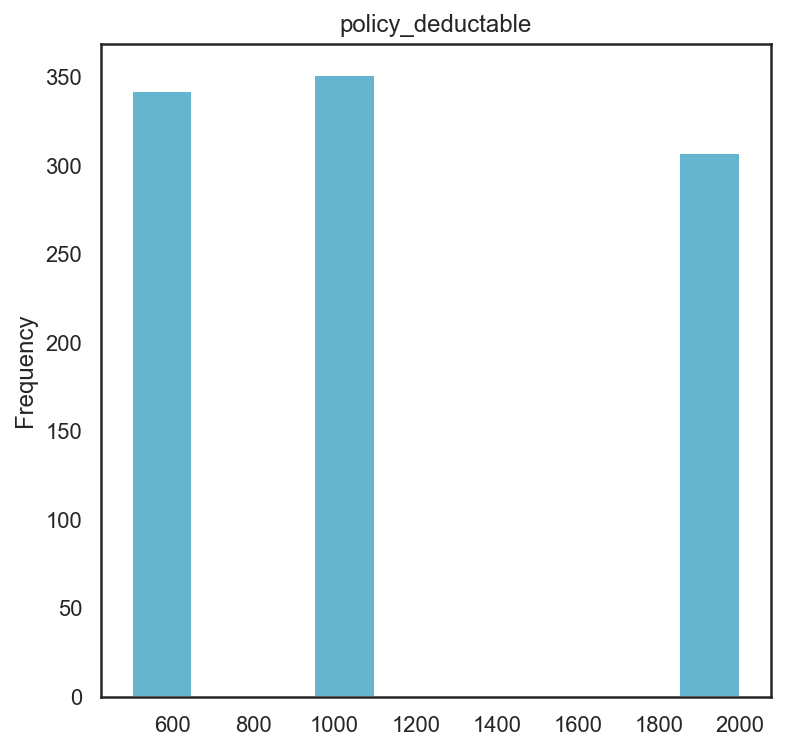

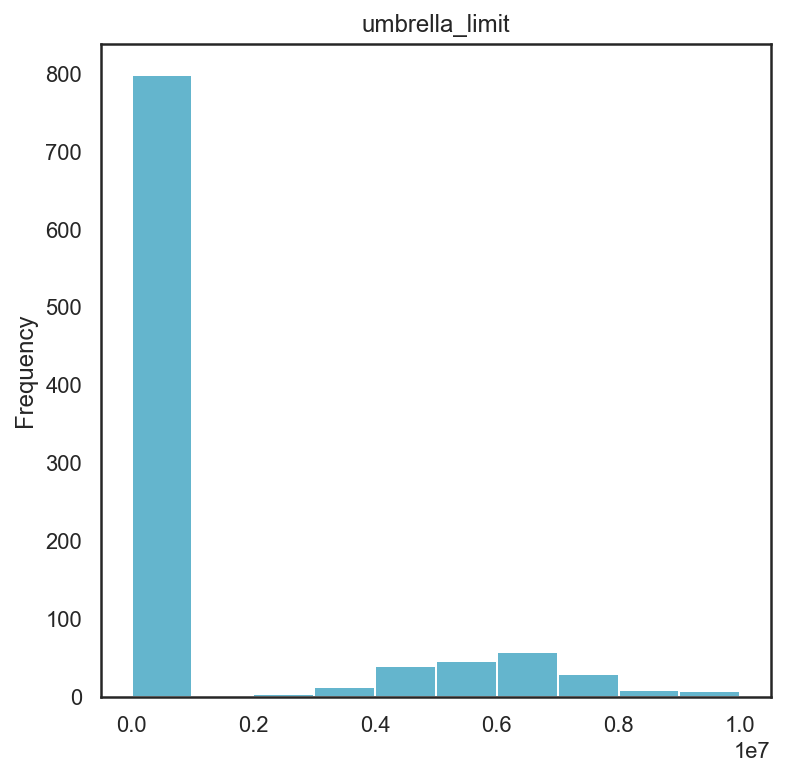

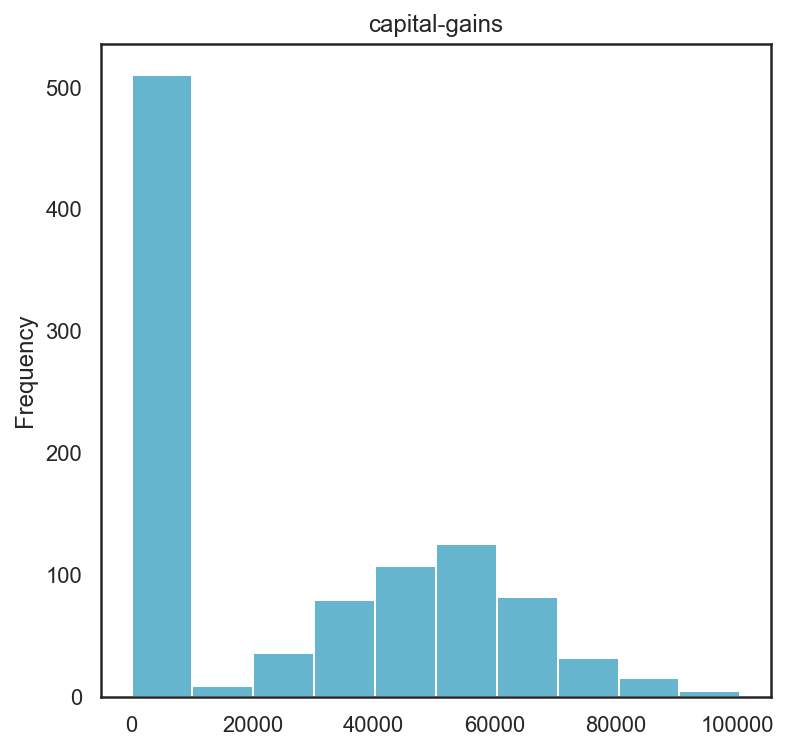

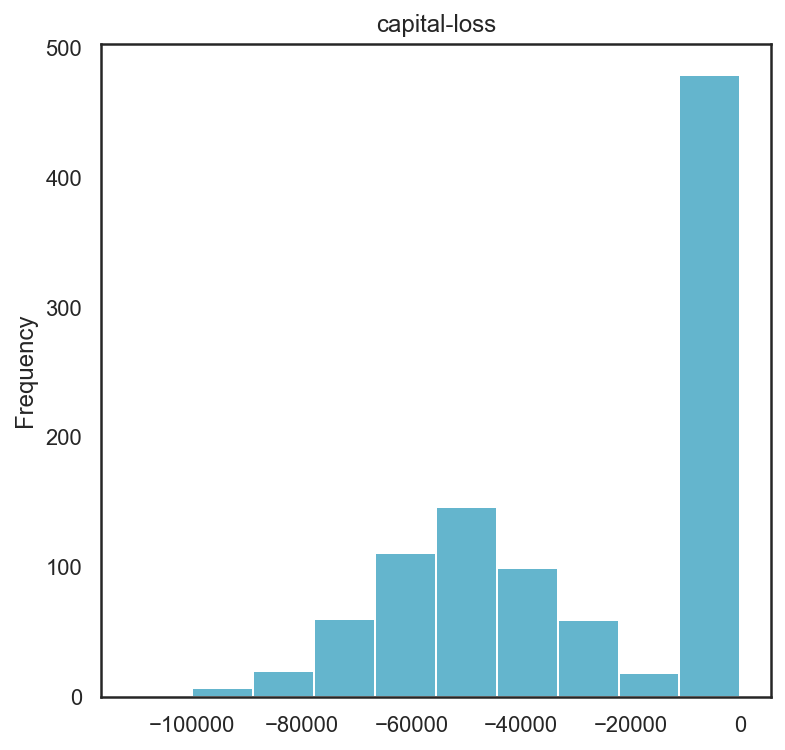

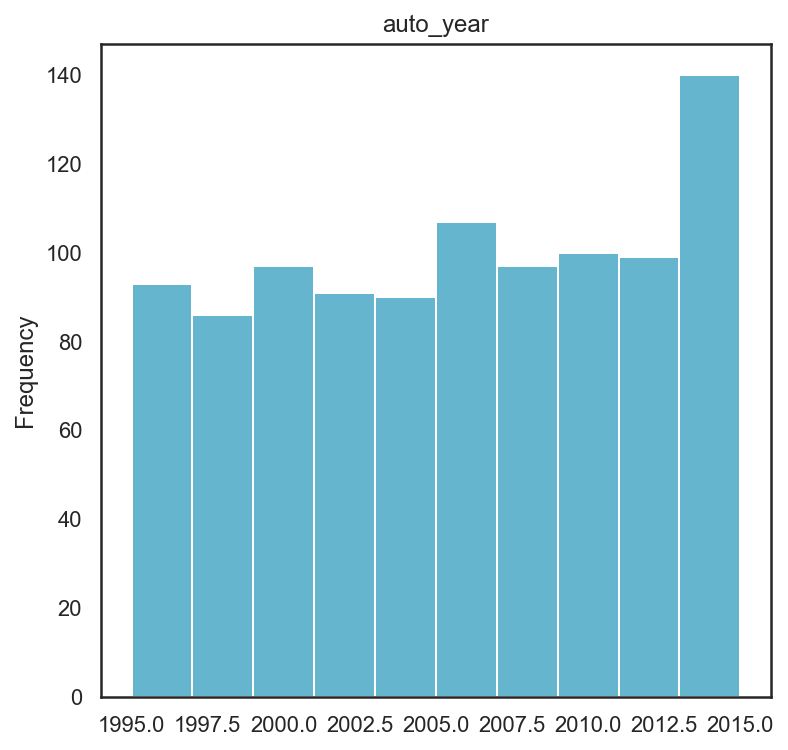

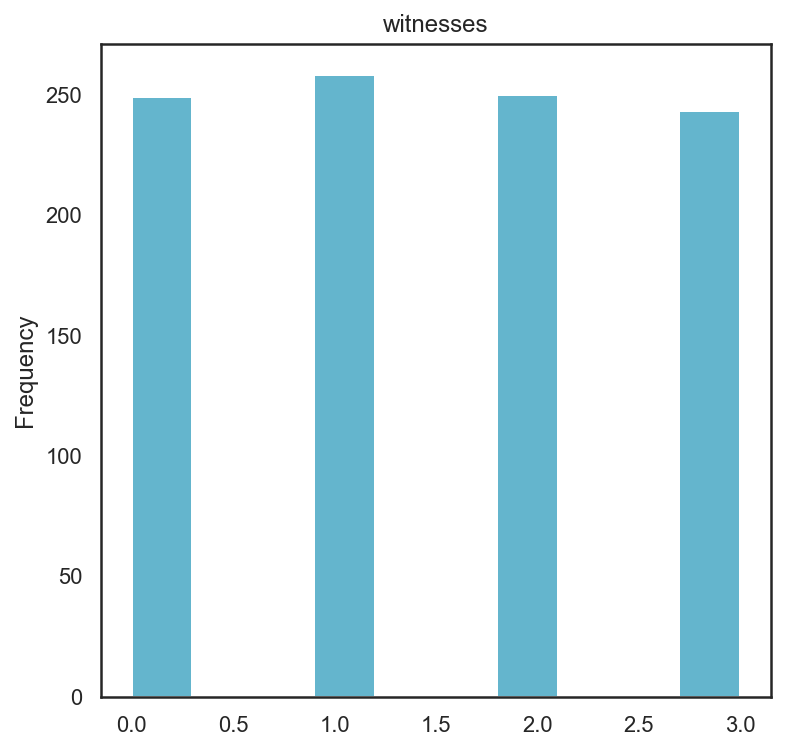

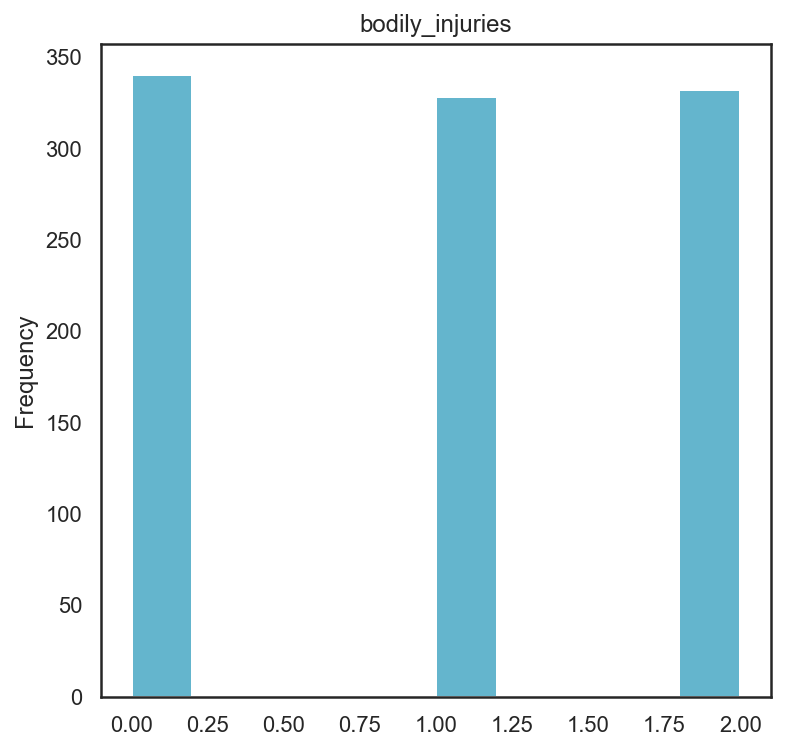

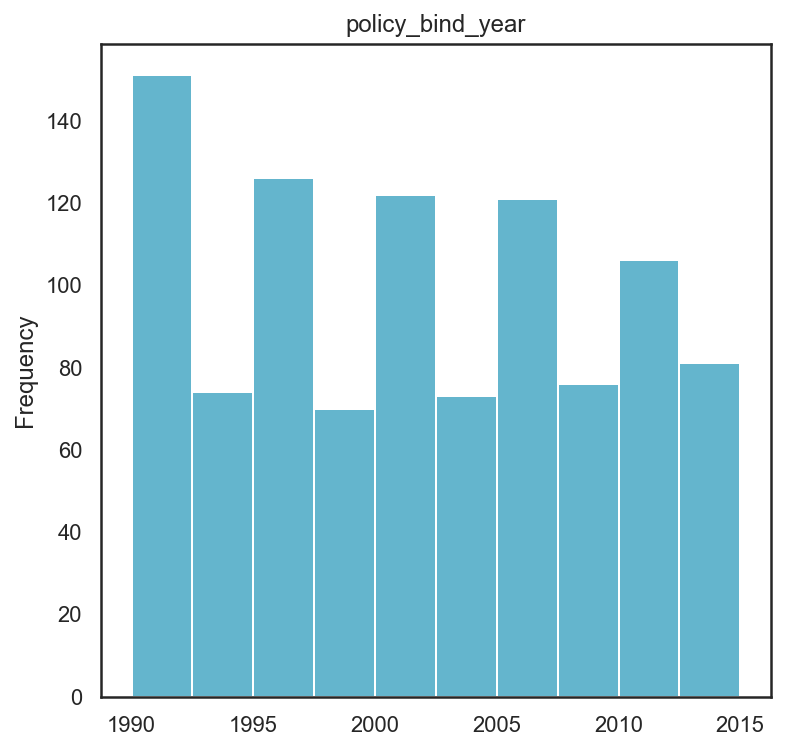

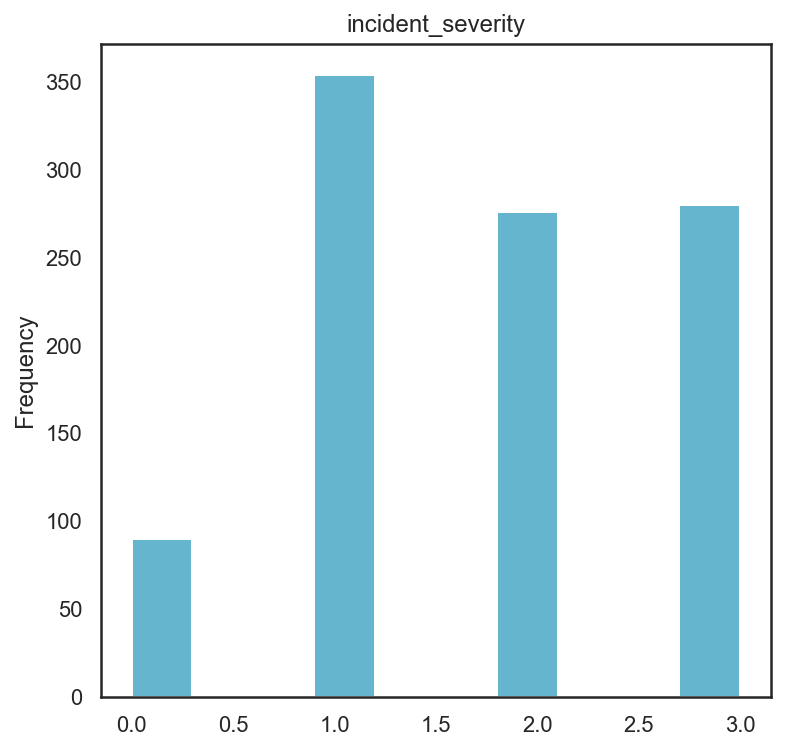

In [36]:

#distribution of ordinal and continuous variables

for i, name in enumerate(df[cont_var]):
    plt.figure(i,figsize=(6,6))
    df[name].plot(kind="hist", color="c", title=name)

In [37]:
#Visualization against the dependent variable

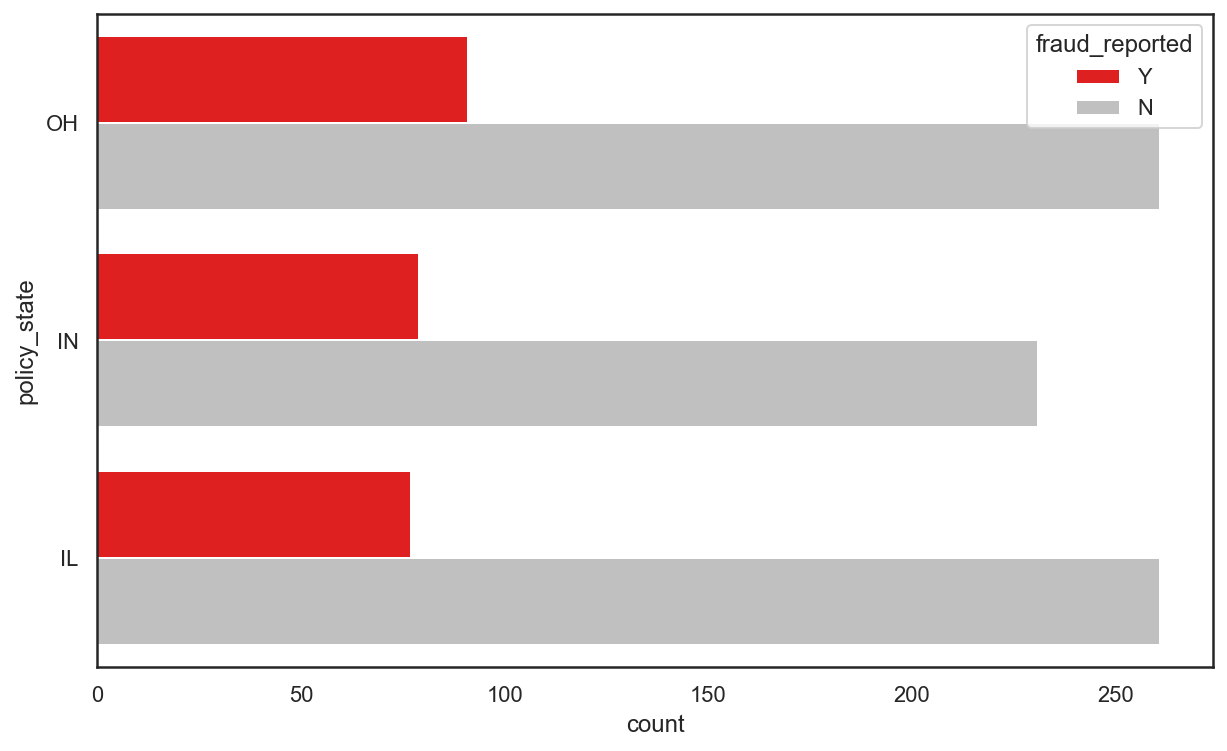

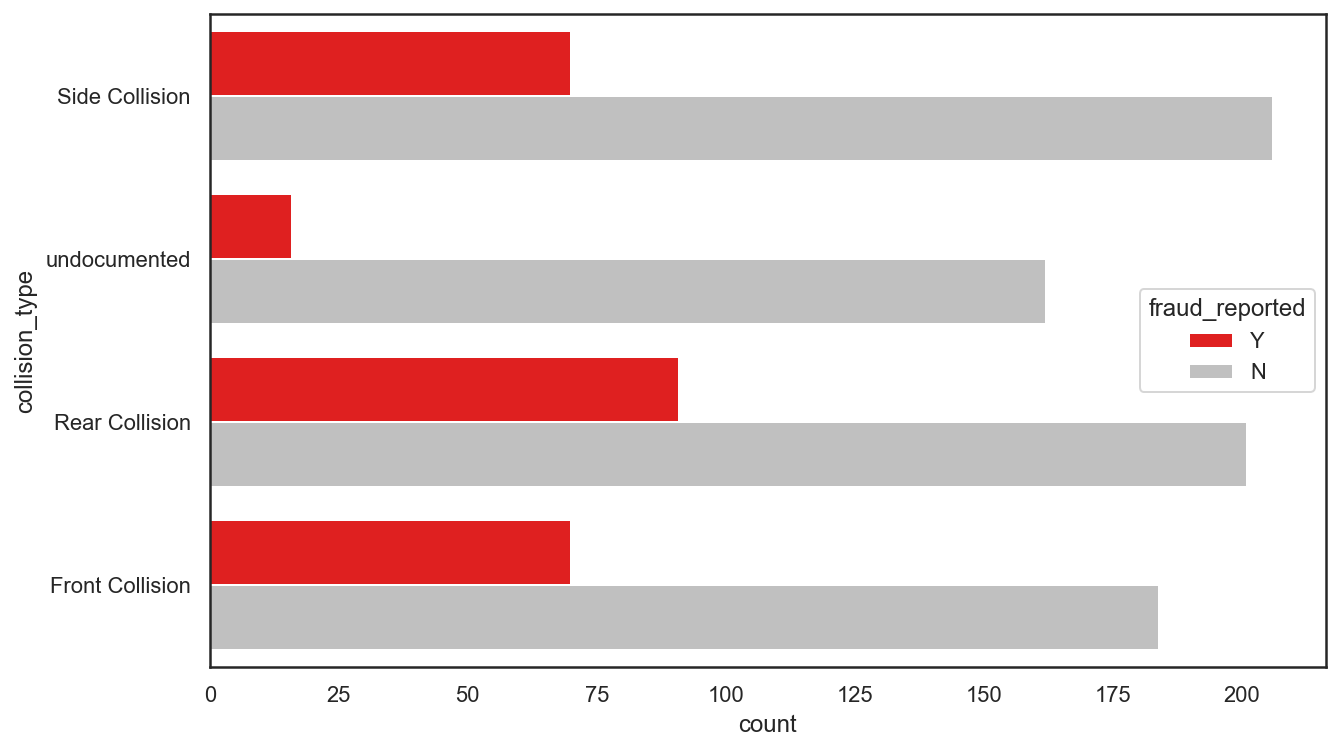

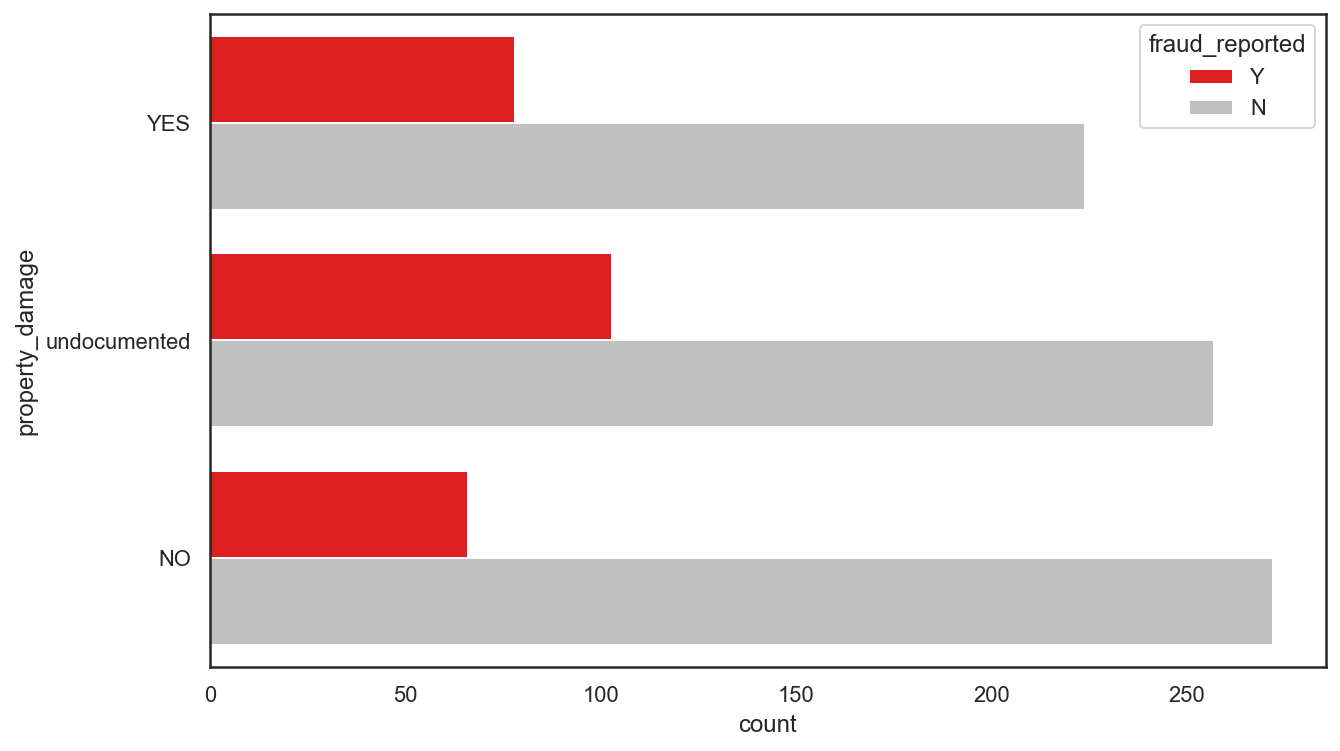

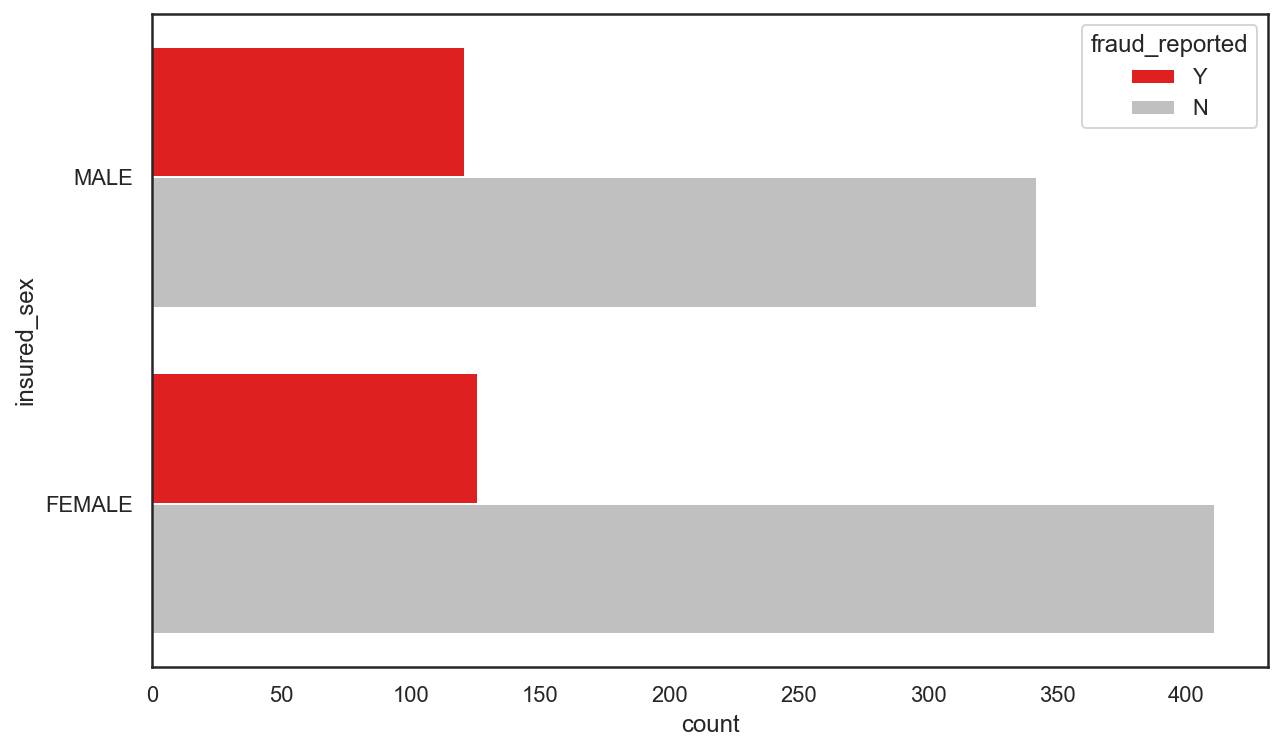

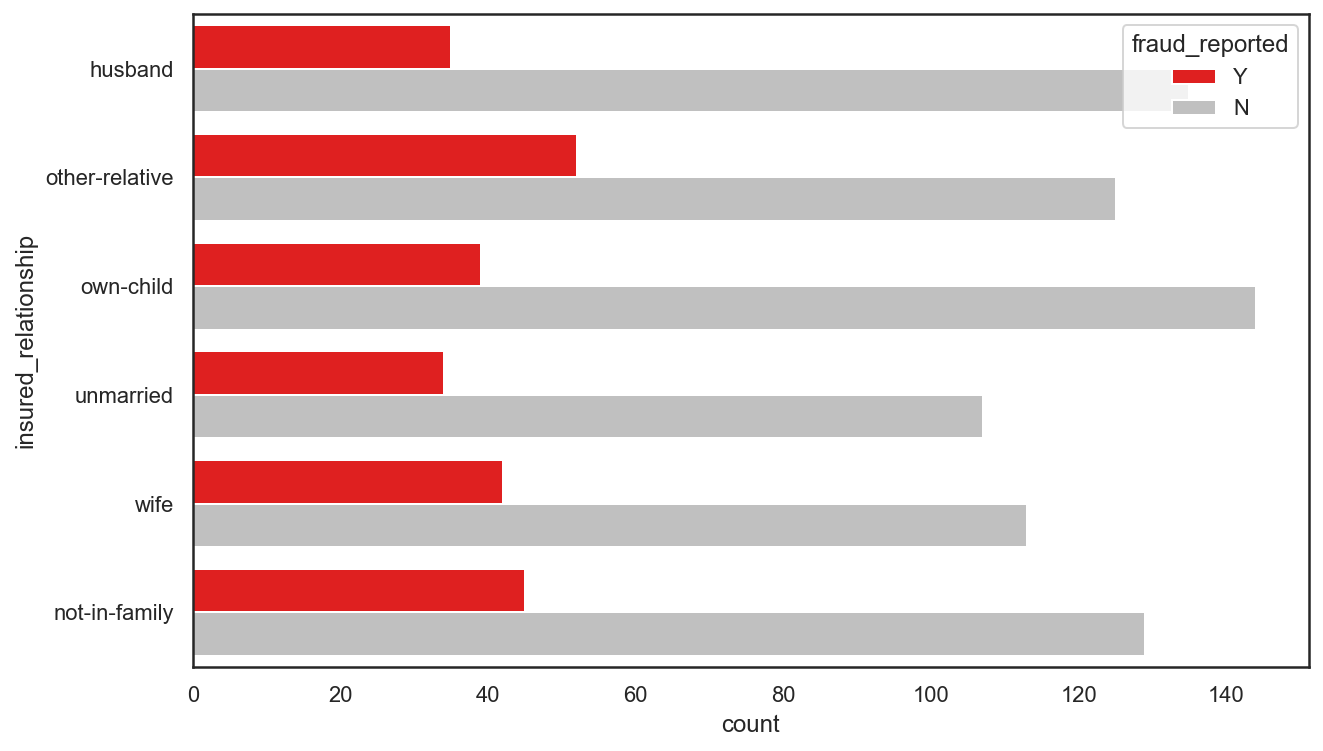

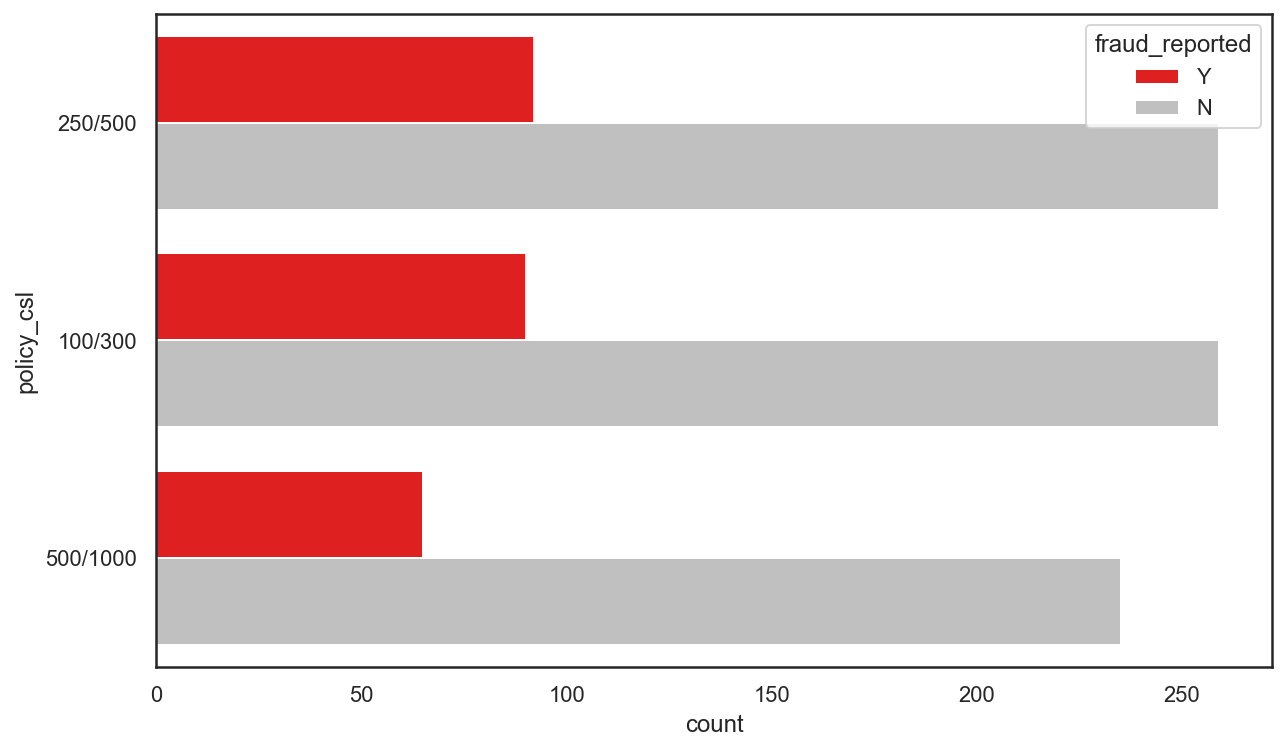

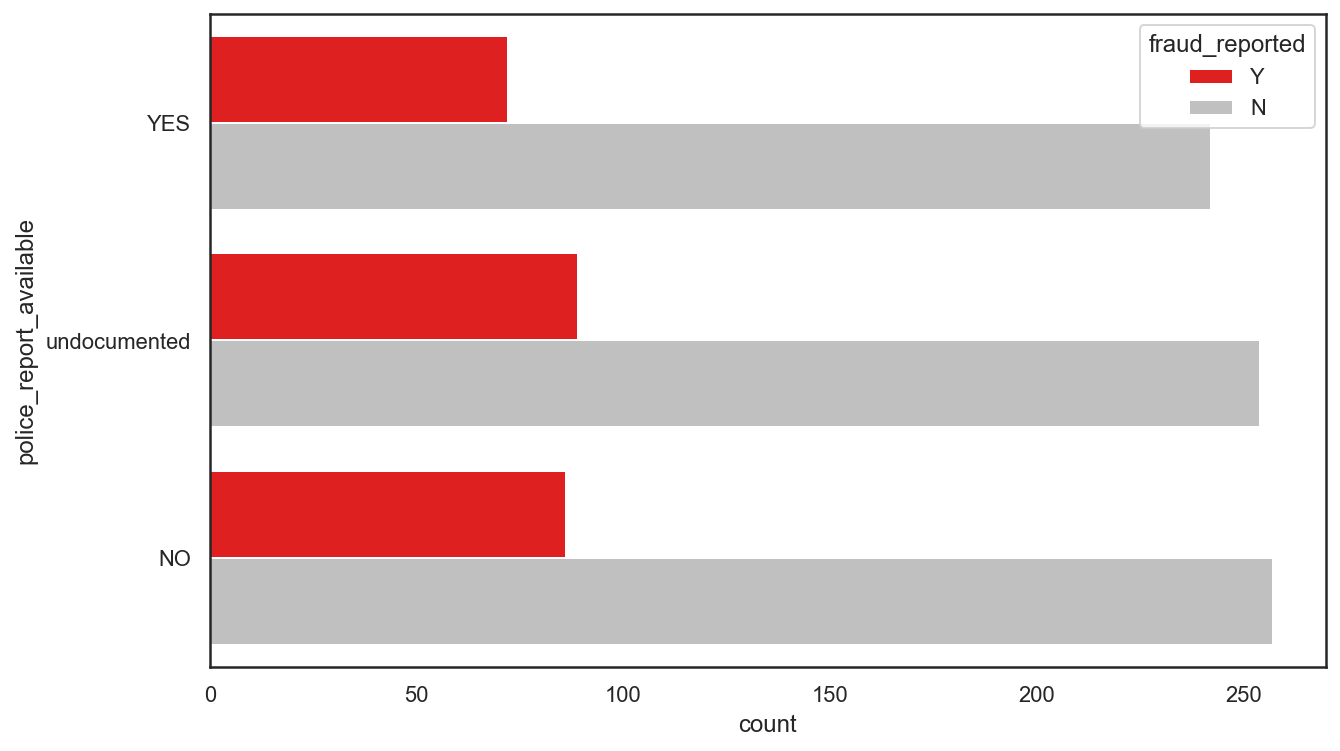

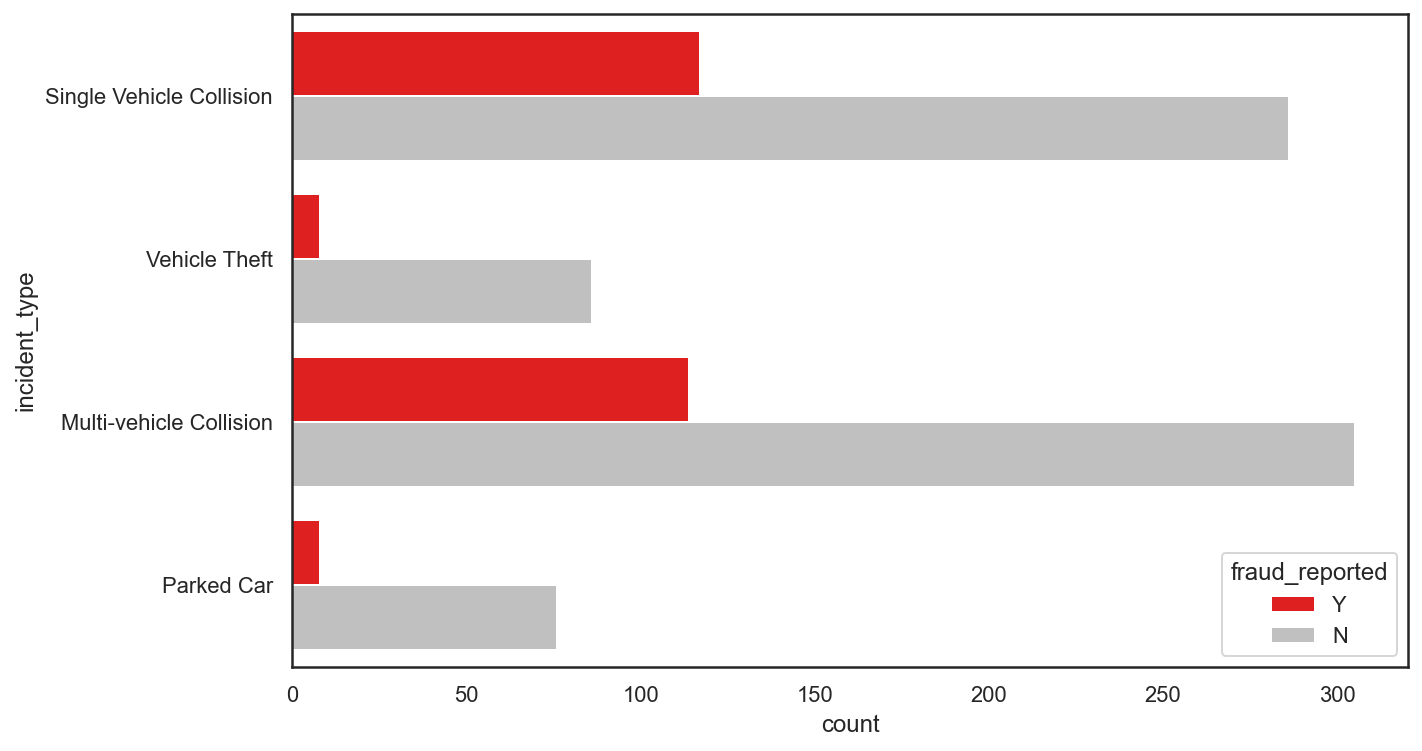

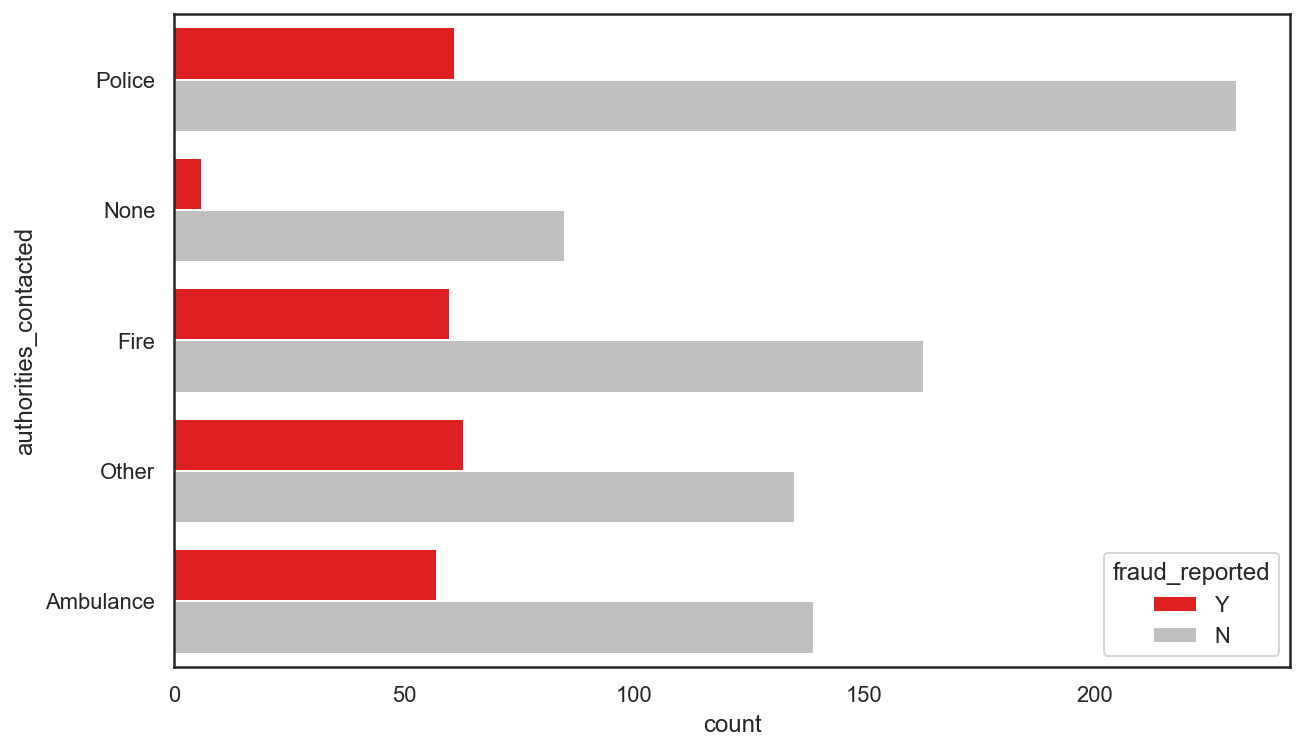

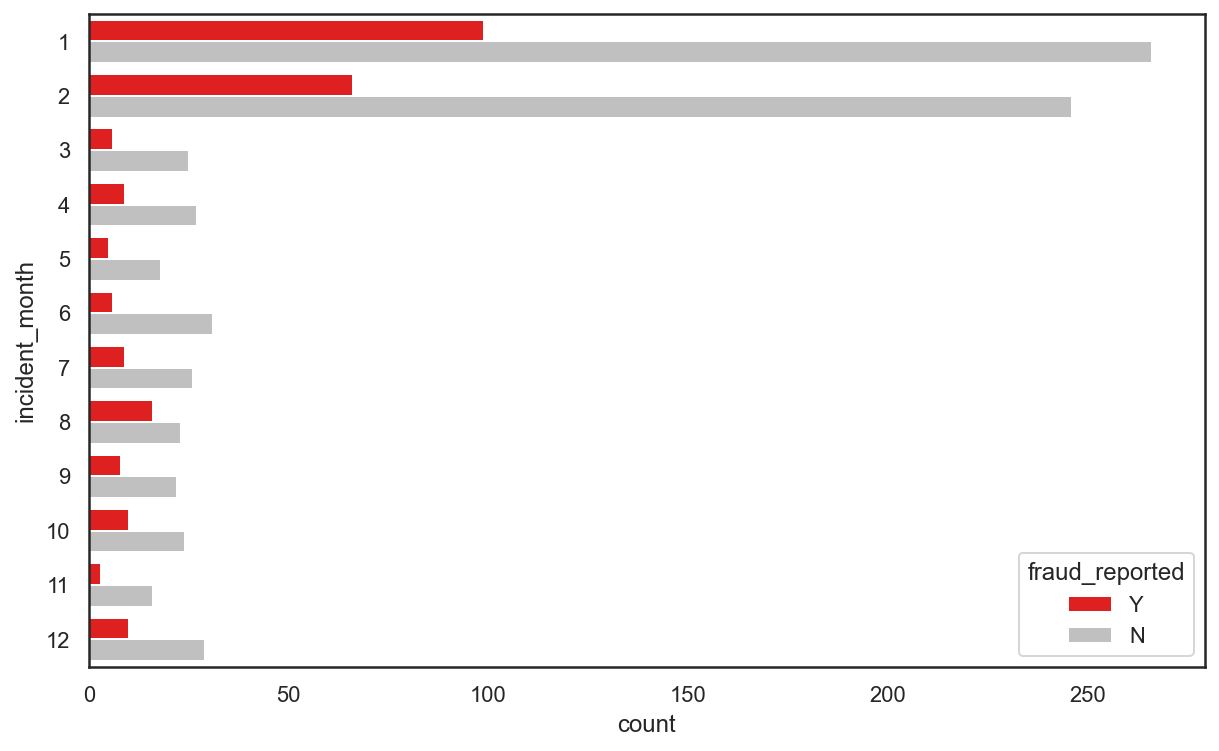

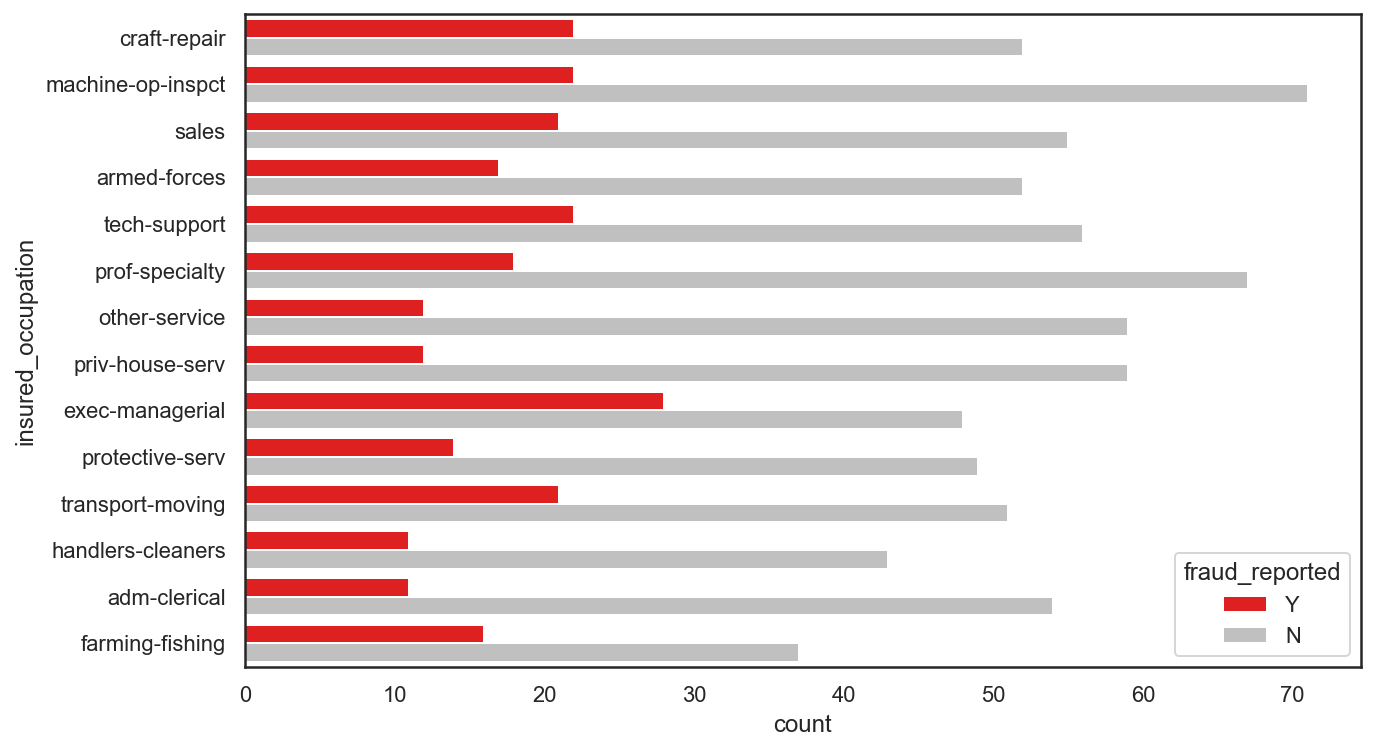

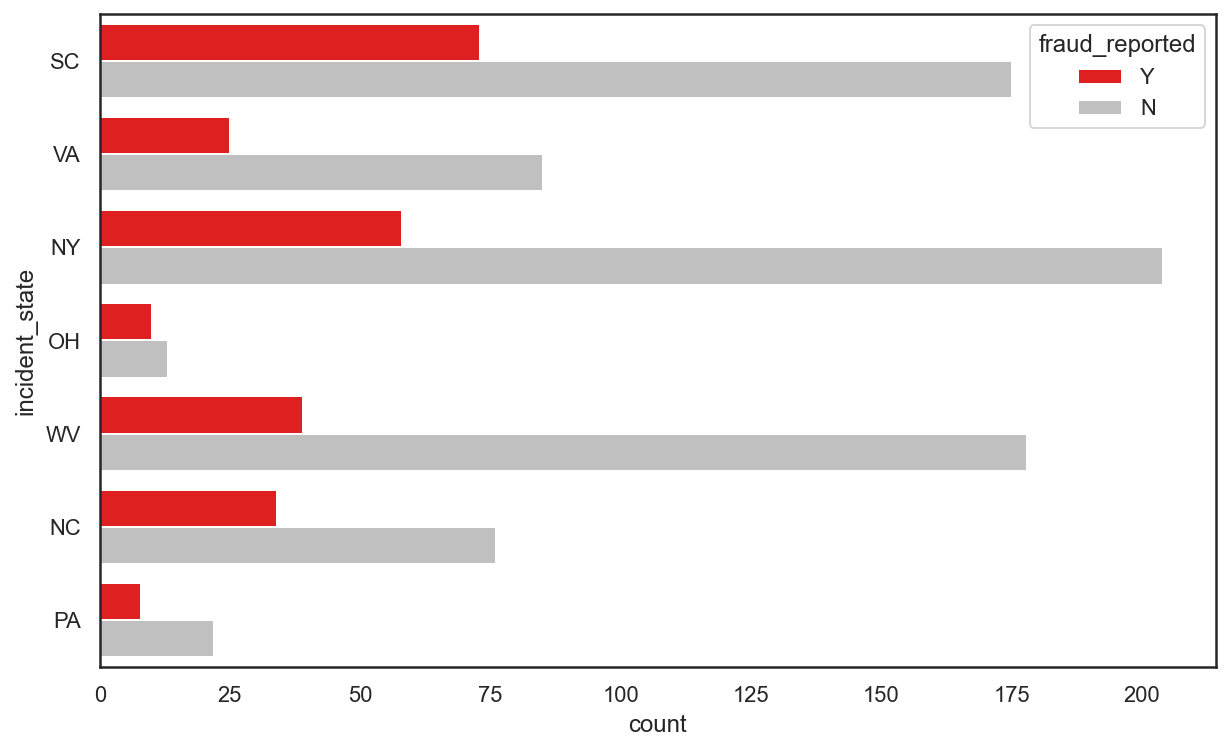

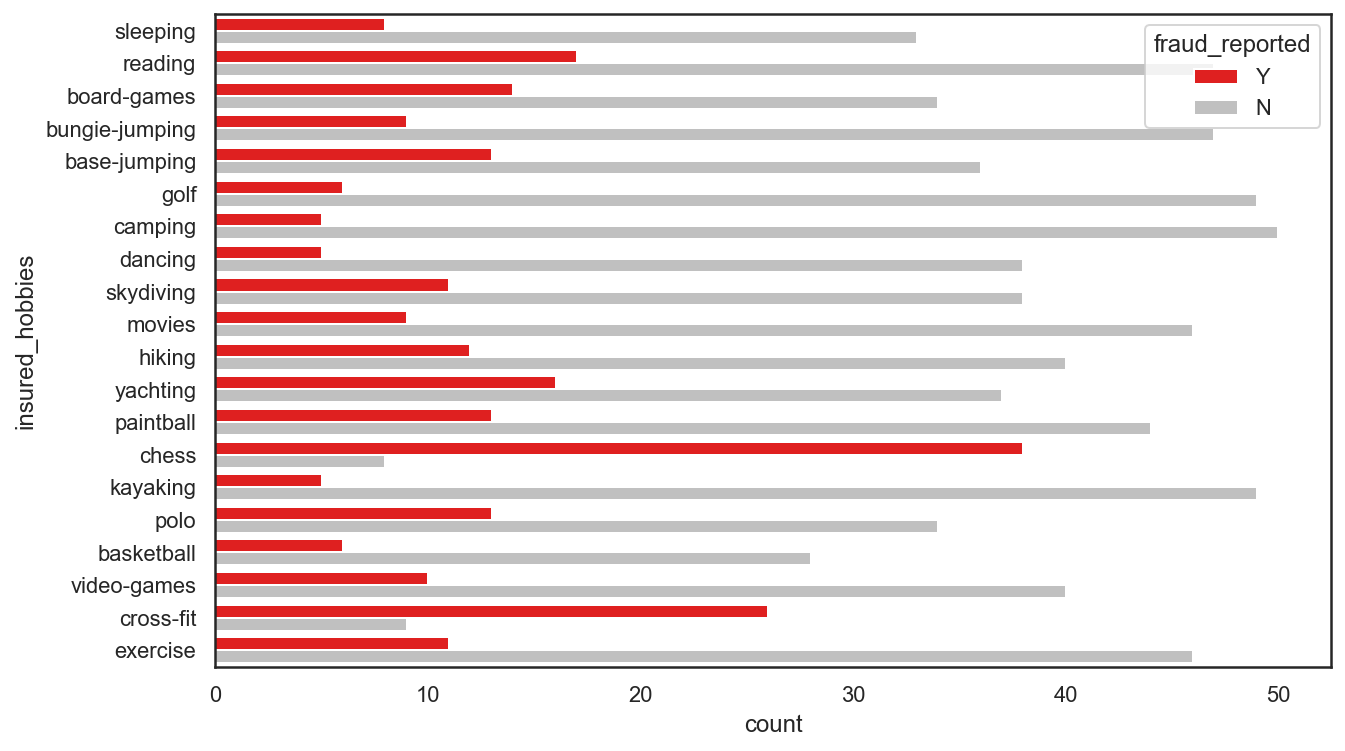

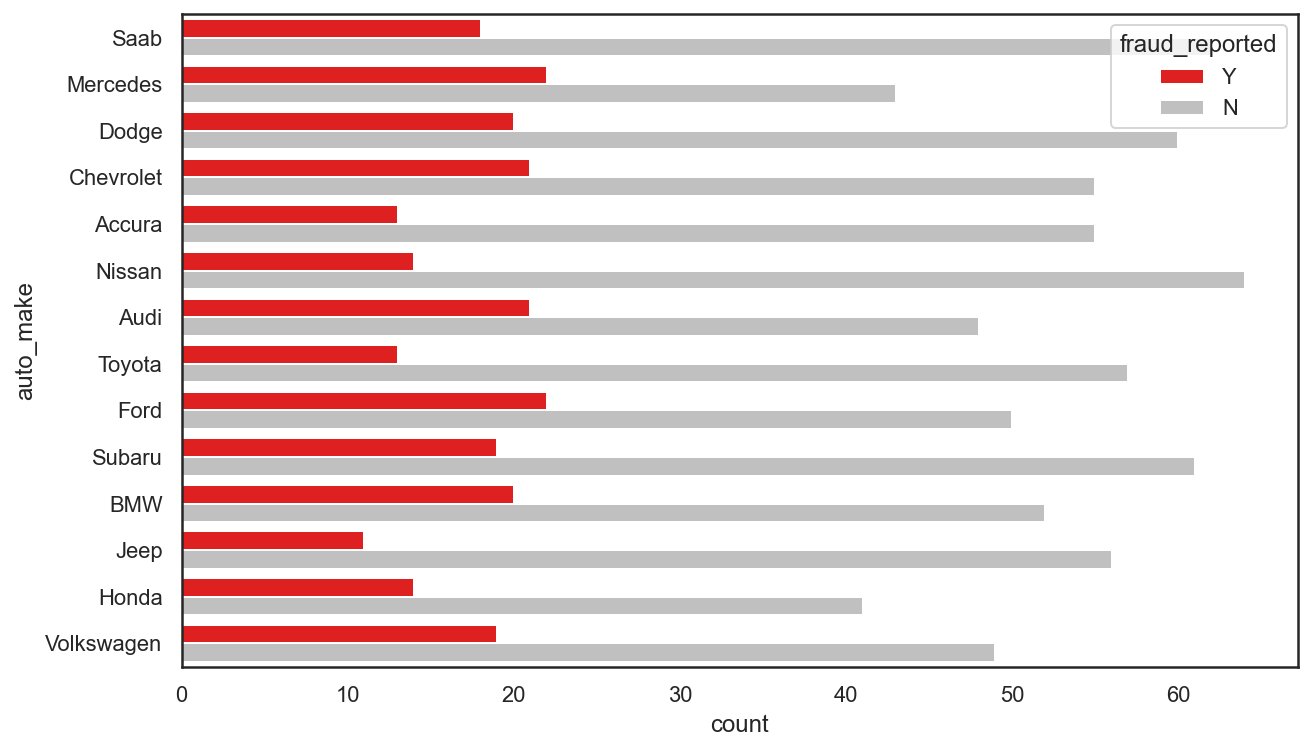

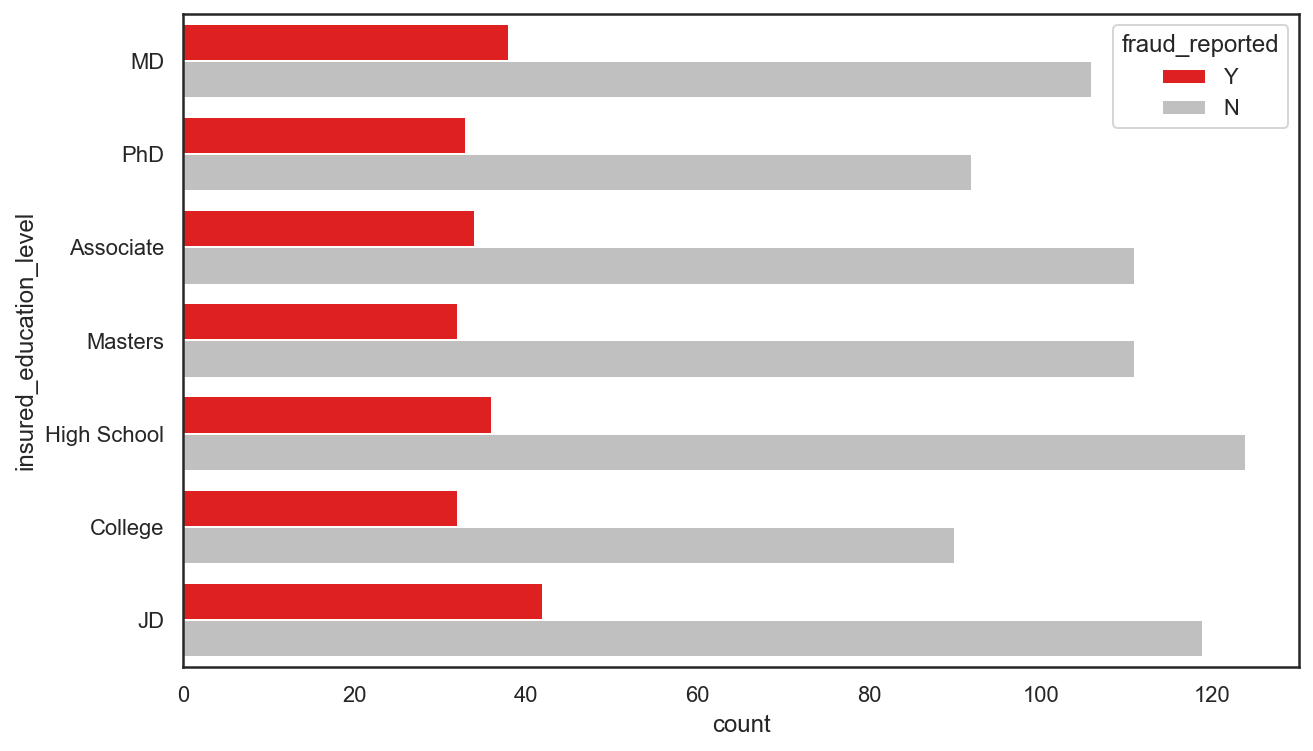

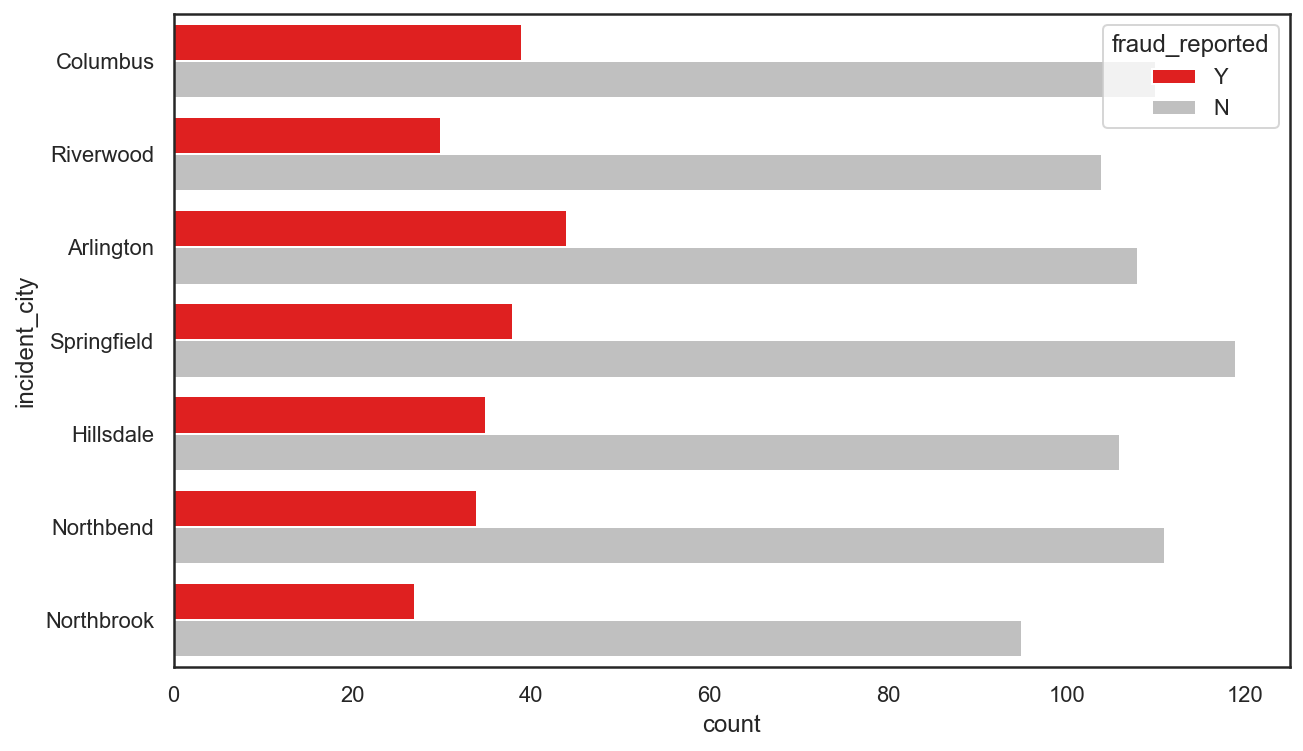

In [38]:
#each discrete var and fraud reported's dist

for i, name in enumerate(df[nom_var]):
    plt.figure(i,figsize=(10,6))
    sns.countplot(y=name, data=df, hue="fraud_reported", palette=['red','silver'])

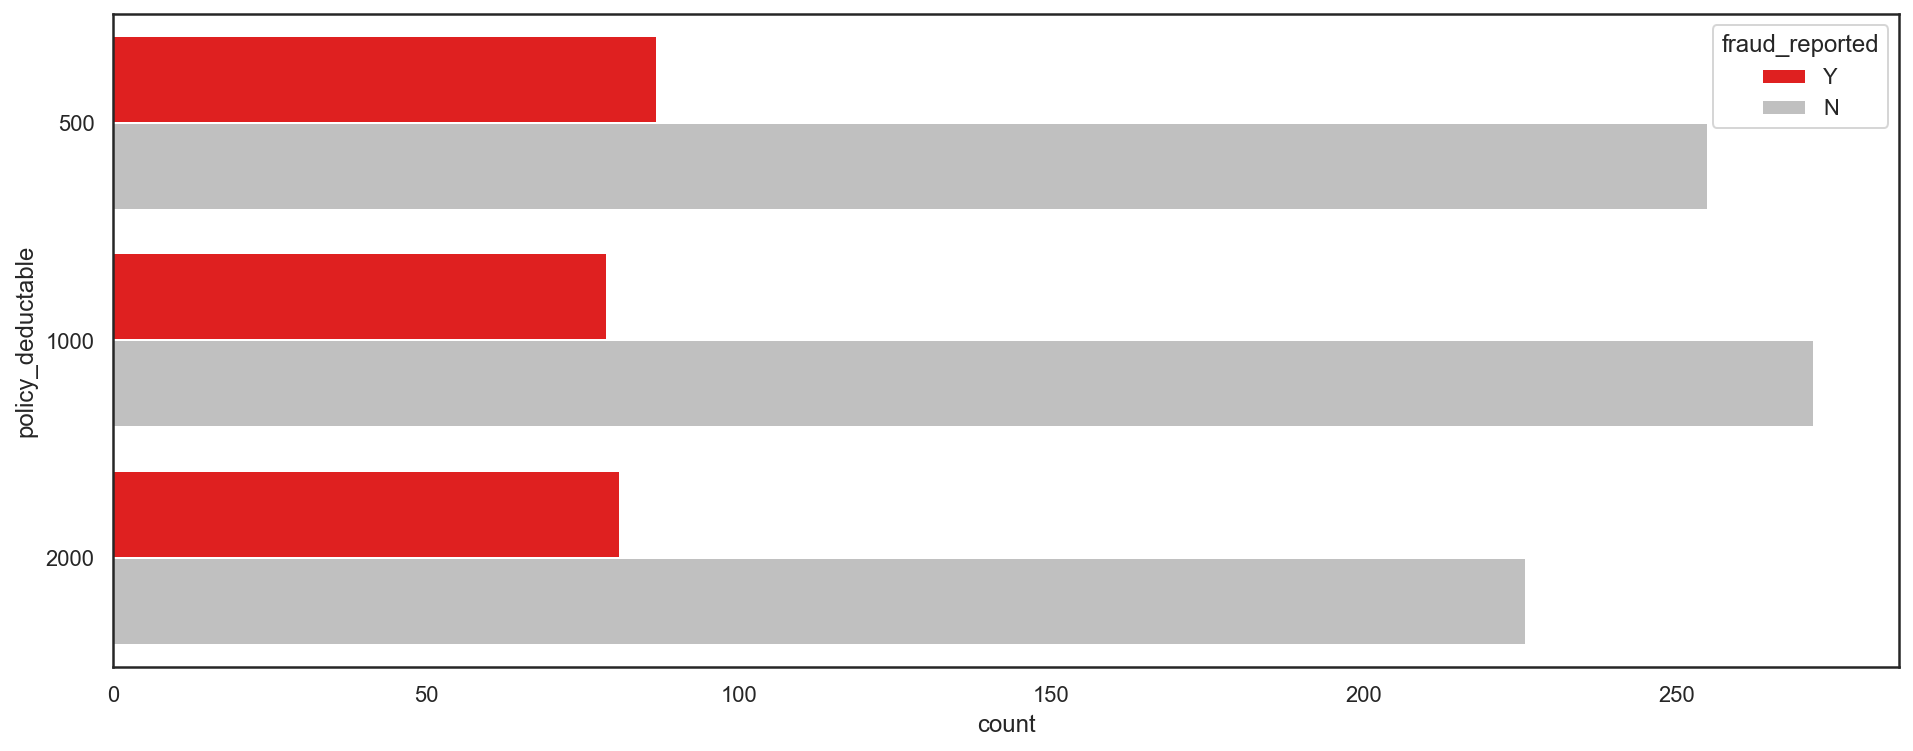

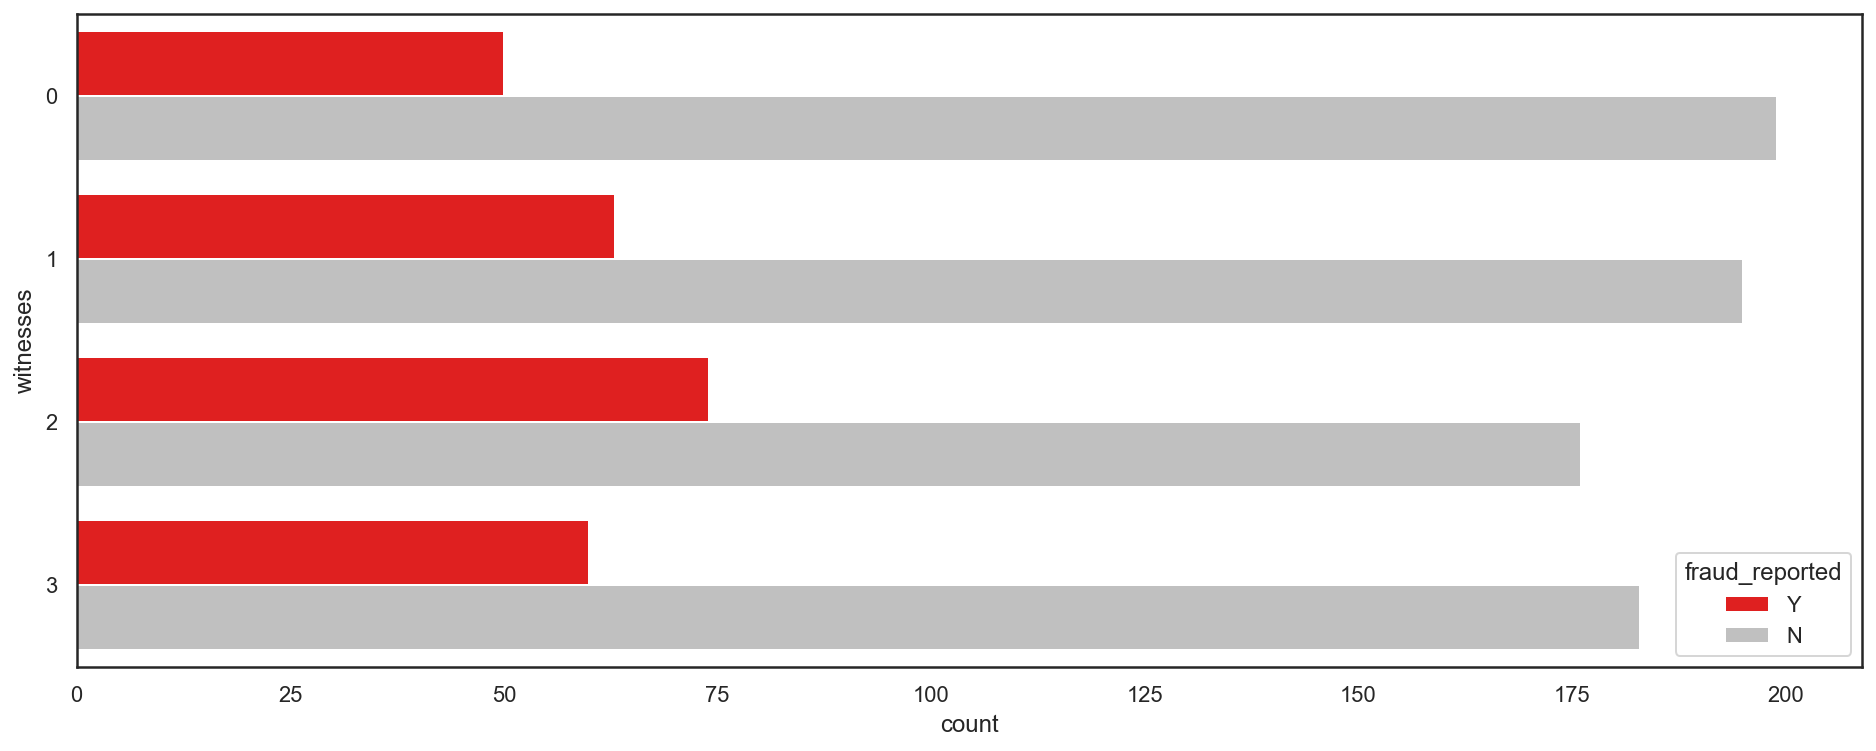

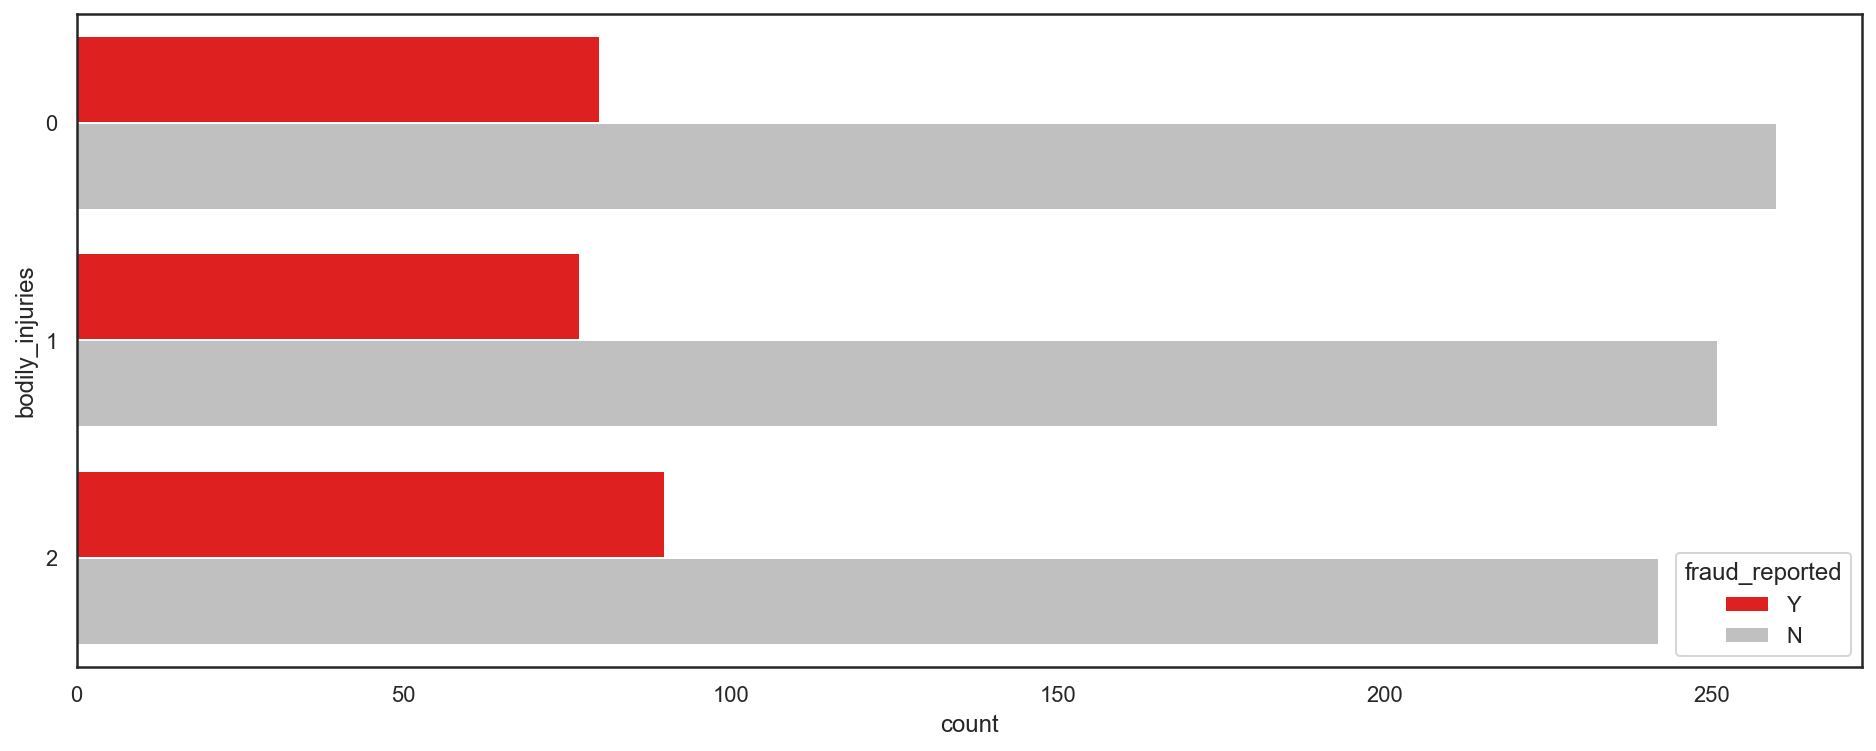

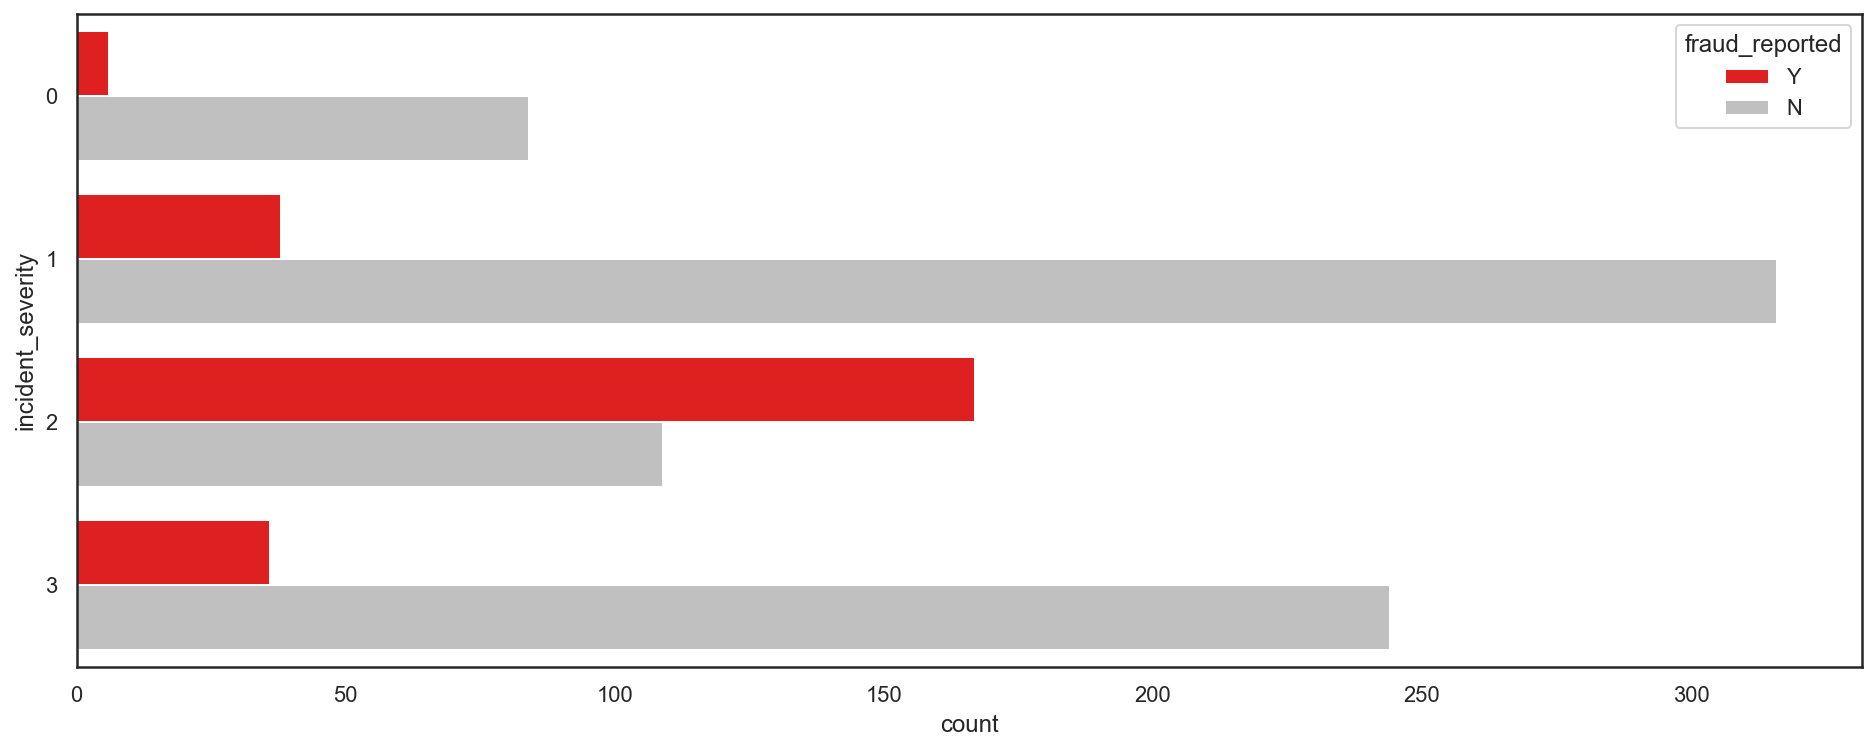

In [39]:
#each ordinal var and fraud reported's dist
#plt.style.use('dark_background')
#plt.style.use('default')


for i, name in enumerate(df[ord_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(data=df, y=name, hue='fraud_reported', palette=['red','silver'])

<Figure size 1152x432 with 0 Axes>

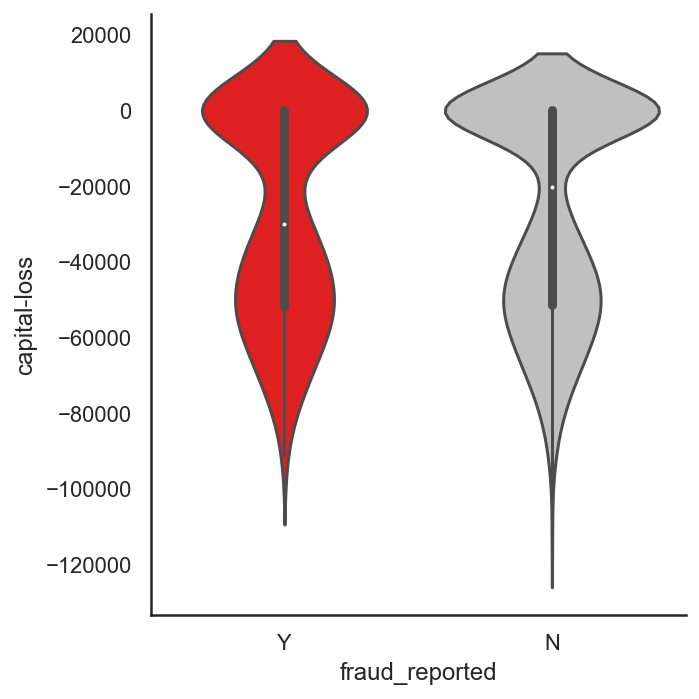

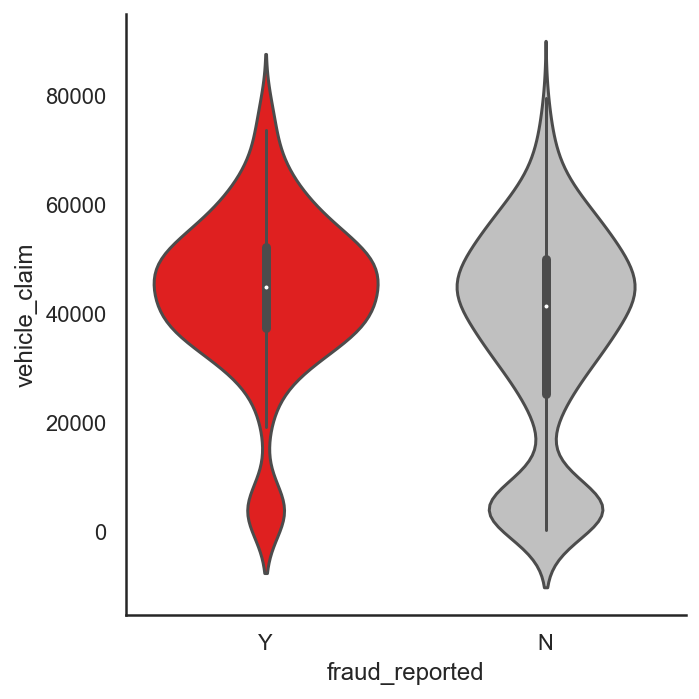

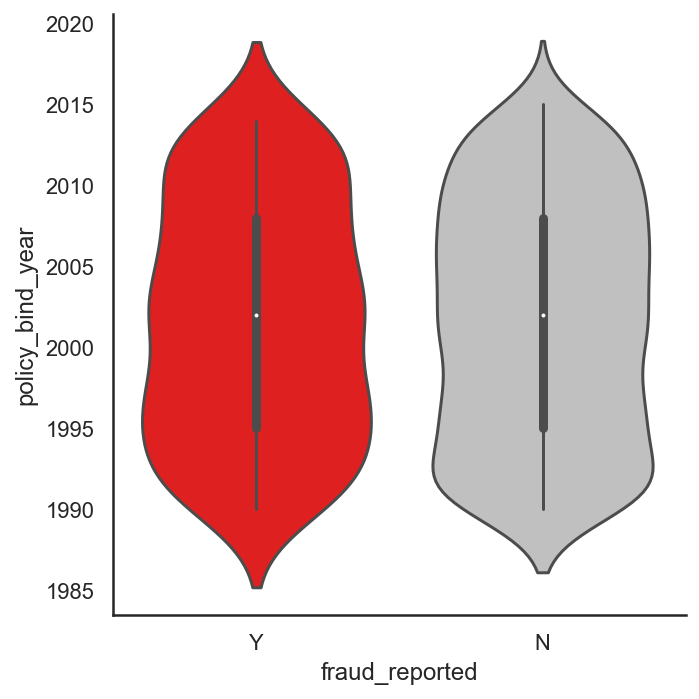

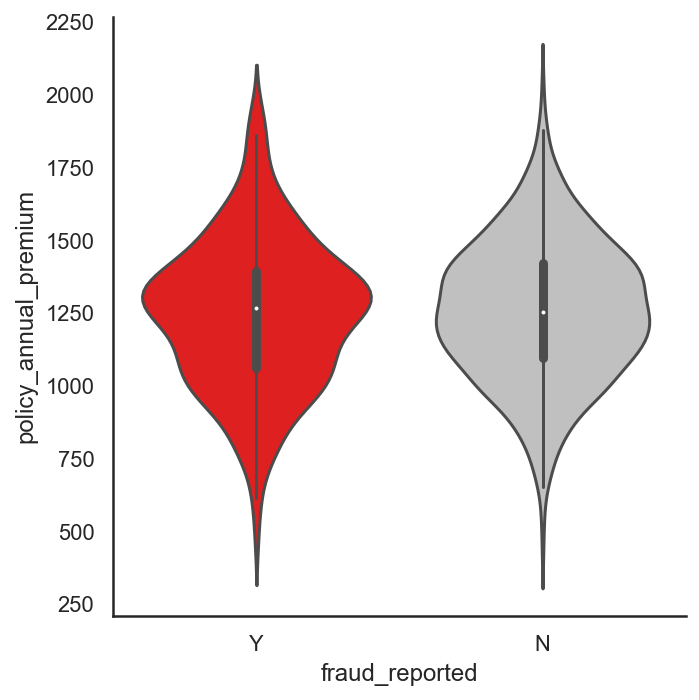

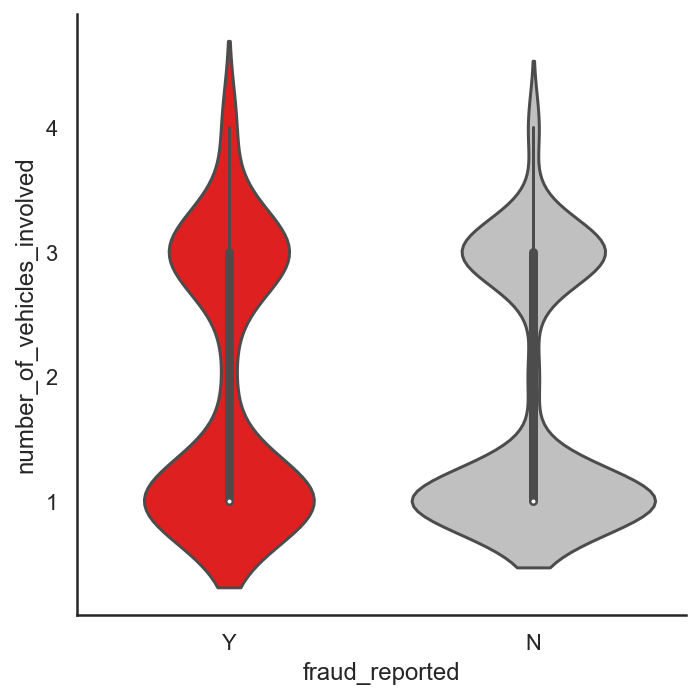

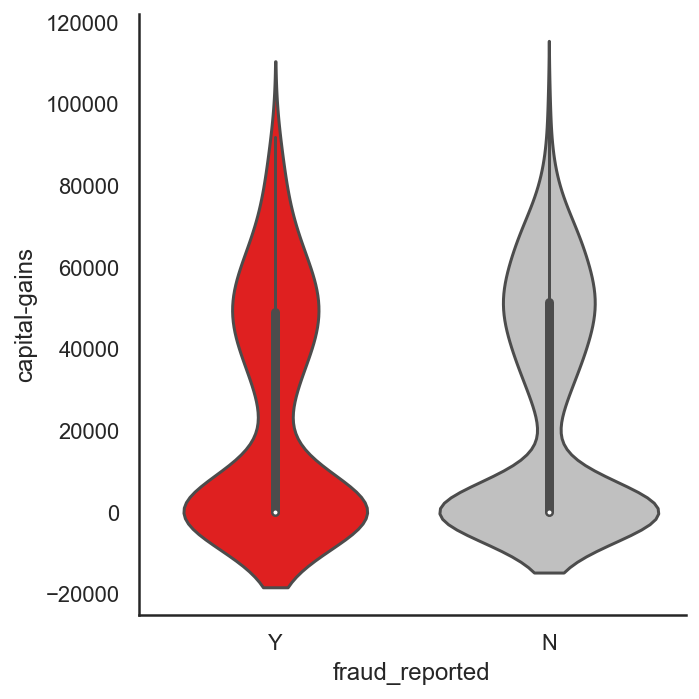

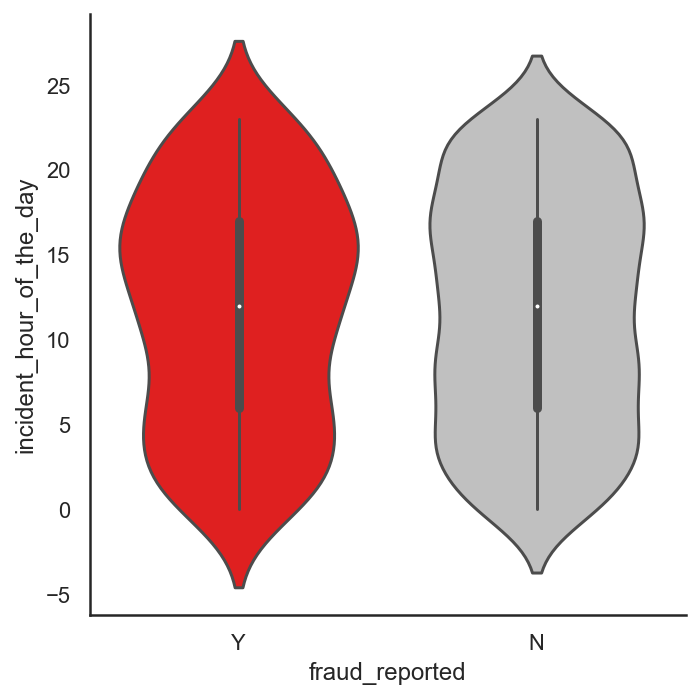

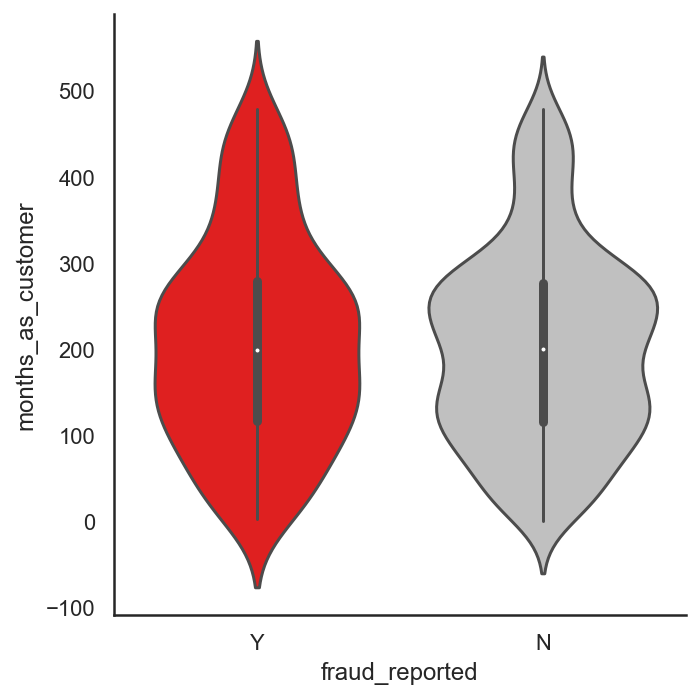

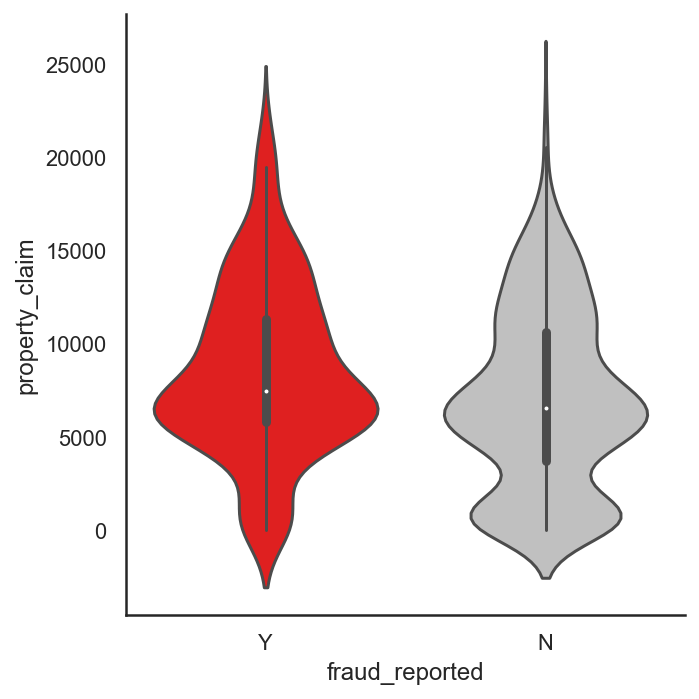

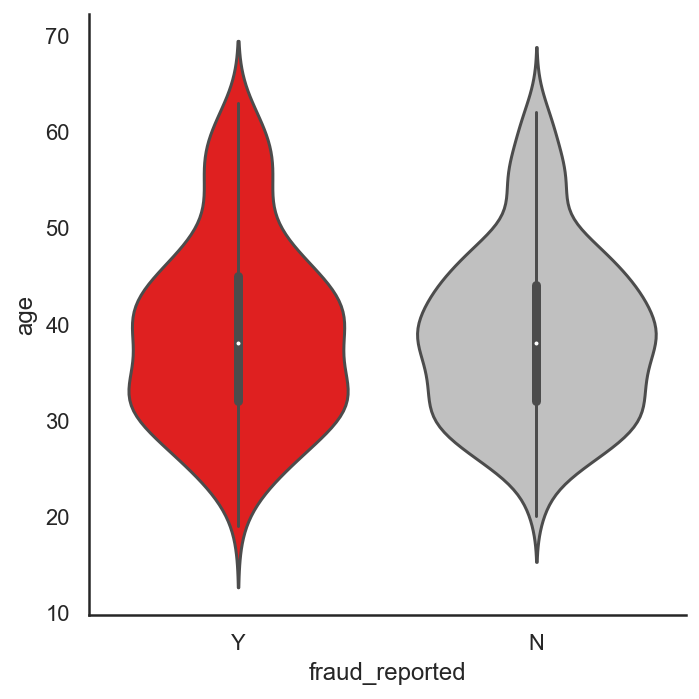

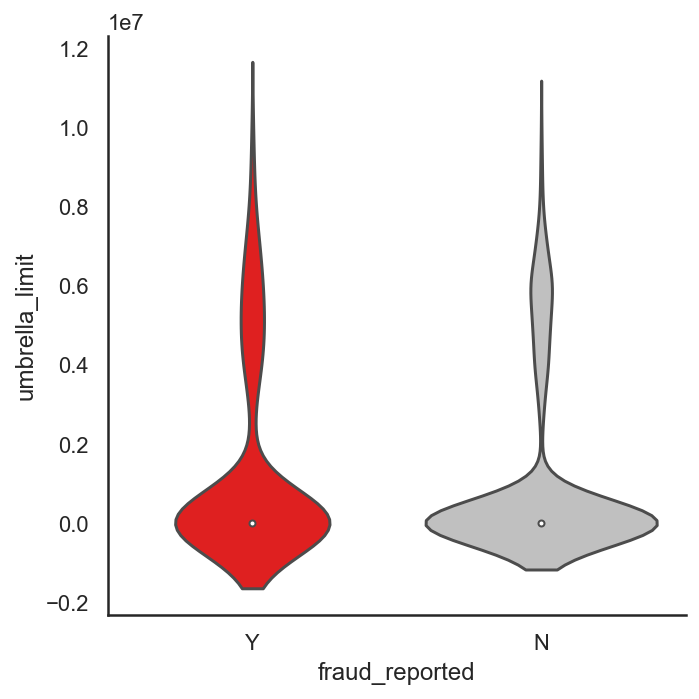

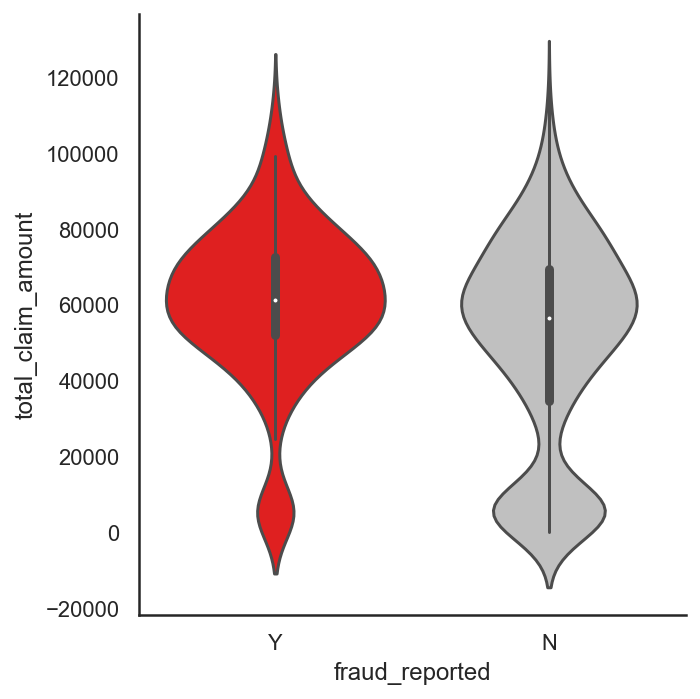

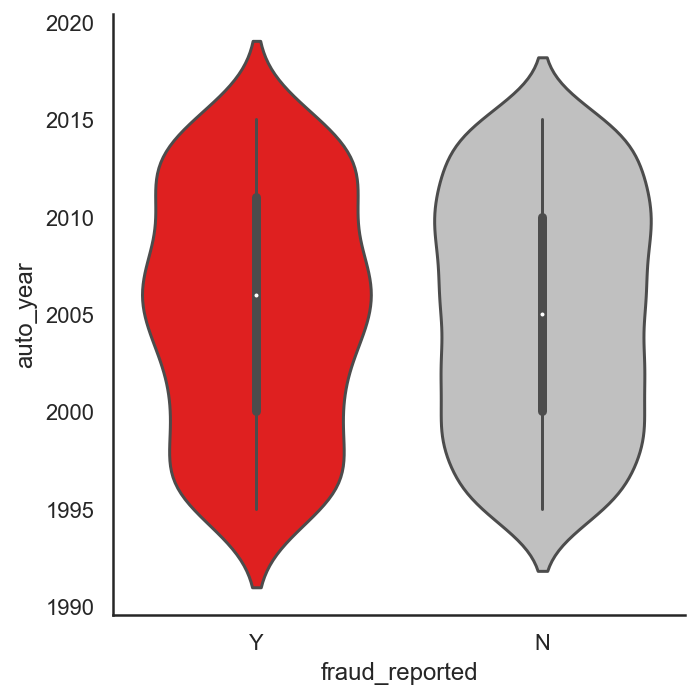

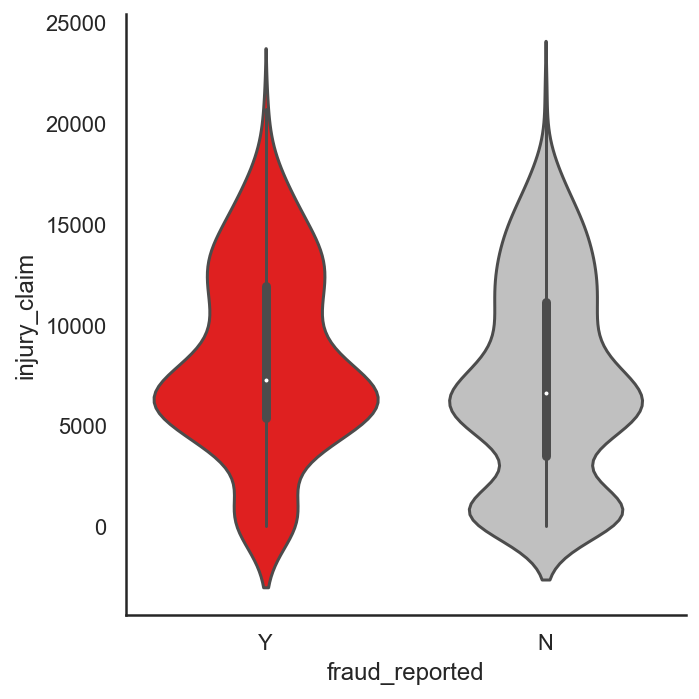

In [40]:

#each continous var and fraud reported's dist

for i, name in enumerate(df[quan_var]):
    plt.figure(i,figsize=(16,6))
    sns.catplot(data=df, x="fraud_reported", y=name, kind='violin', palette=['red','silver'])

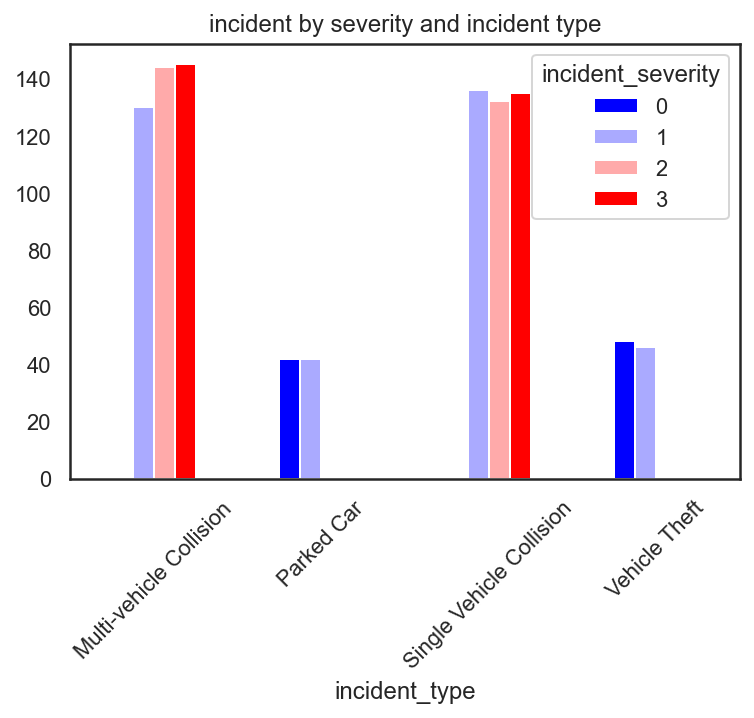

In [41]:
#cross tab of incident type and severity 
#more severe accidents seem to only be present with collision 

incident = pd.crosstab(df['incident_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr',figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and incident type");

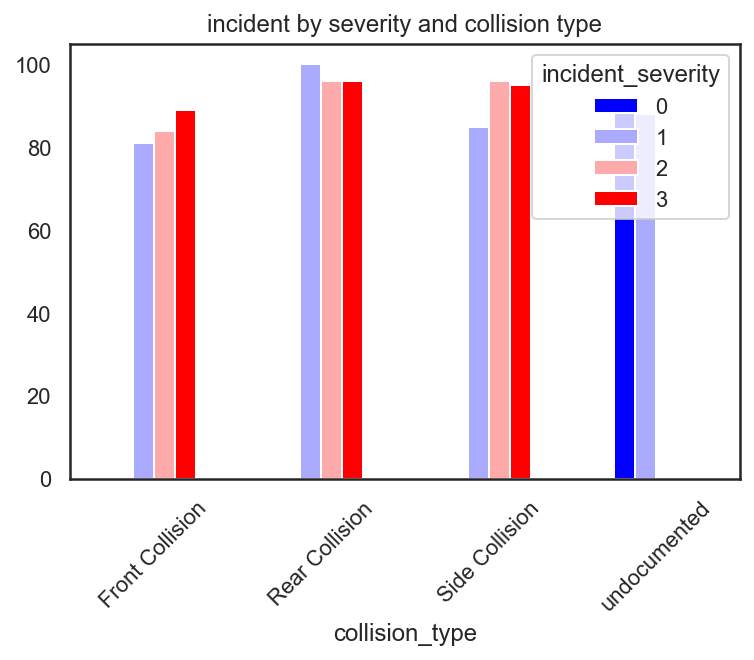

In [42]:
#undocumented collision types tend to be less severe

incident = pd.crosstab(df['collision_type'], df['incident_severity'])

incident.plot(kind='bar', colormap='bwr', figsize=(6,4))
plt.xticks(rotation=45)
plt.title("incident by severity and collision type");

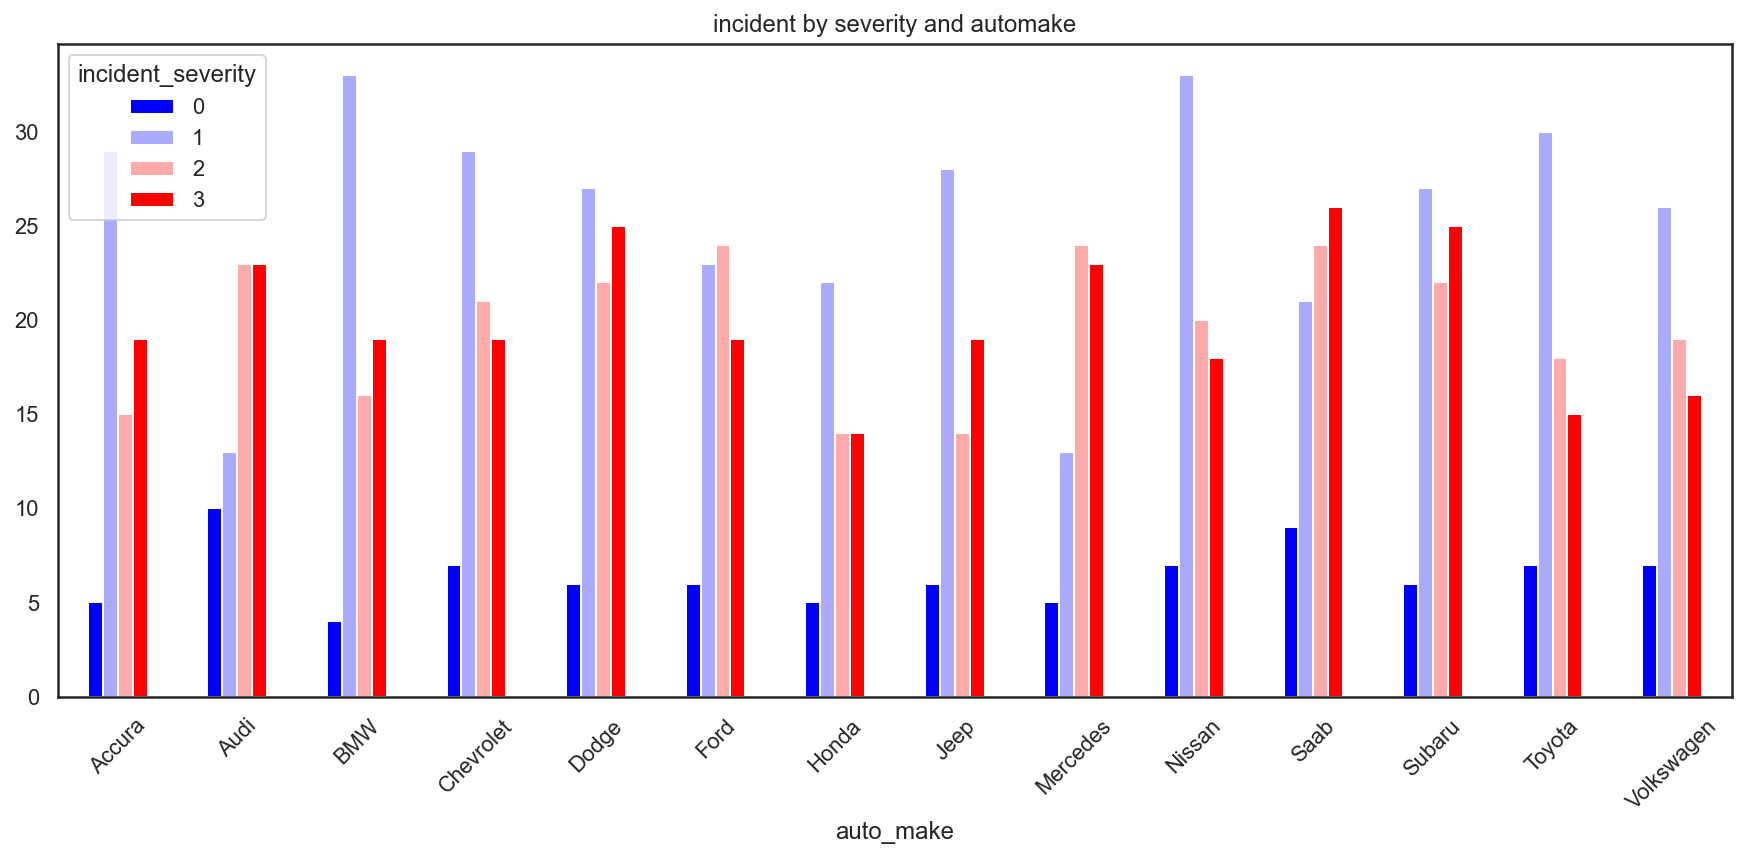

In [43]:
# seems like bmw and nissan gets a lot of minor accident
# fiercer cars like dodge, subaru, saab, merc get into mor severe accident

incident = pd.crosstab(df['auto_make'], df['incident_severity'])
incident.plot(kind='bar', colormap='bwr',figsize=(15,6))
plt.xticks(rotation=45)
plt.title("incident by severity and automake");

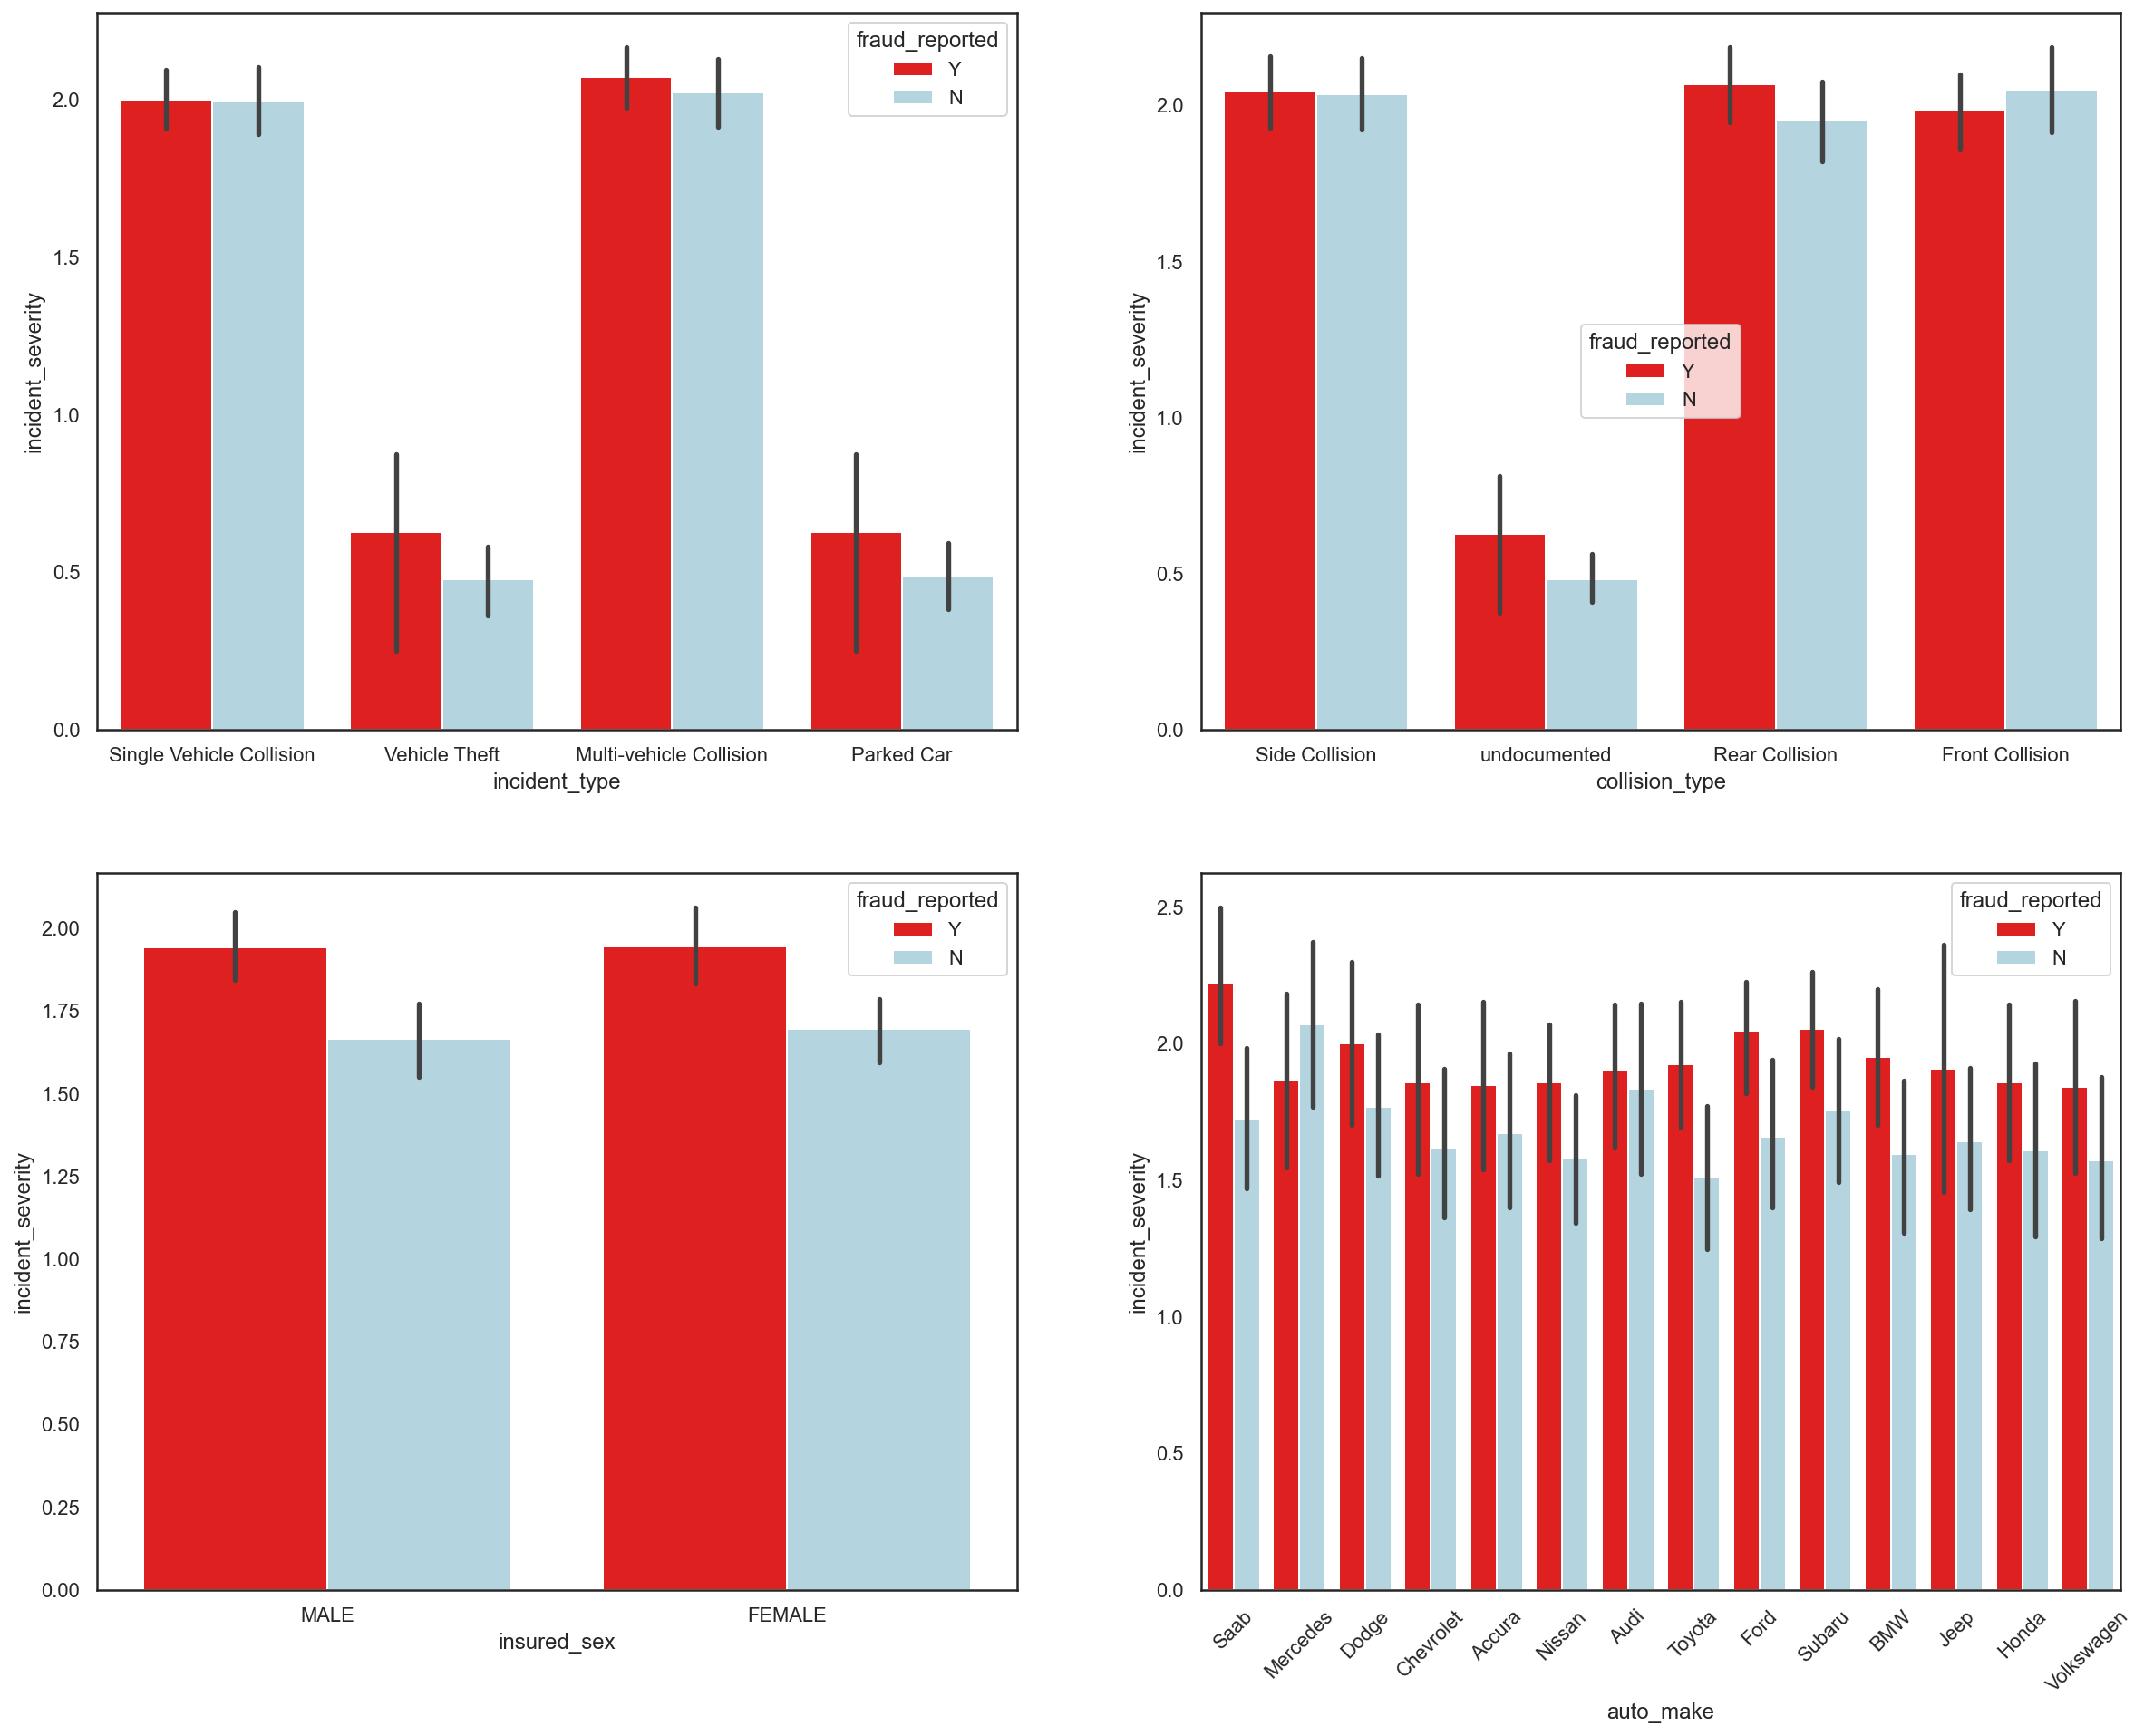

In [44]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="collision_type", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="insured_sex", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="auto_make", y="incident_severity",
                hue="fraud_reported", 
                data=df, palette=['red','lightblue'], ax=axes[1][1]);

plt.xticks(rotation=45);

# although theft and parked car are less severe, they have more fraud cases.. maybe acrimony and vengeful?
# rear collision and undocumented have more fraud.. again we see a trend that less severe accidetns more fraud (undoc)
# no obvious trend by sex 
#saab subaru ford seem to have more fraud cases

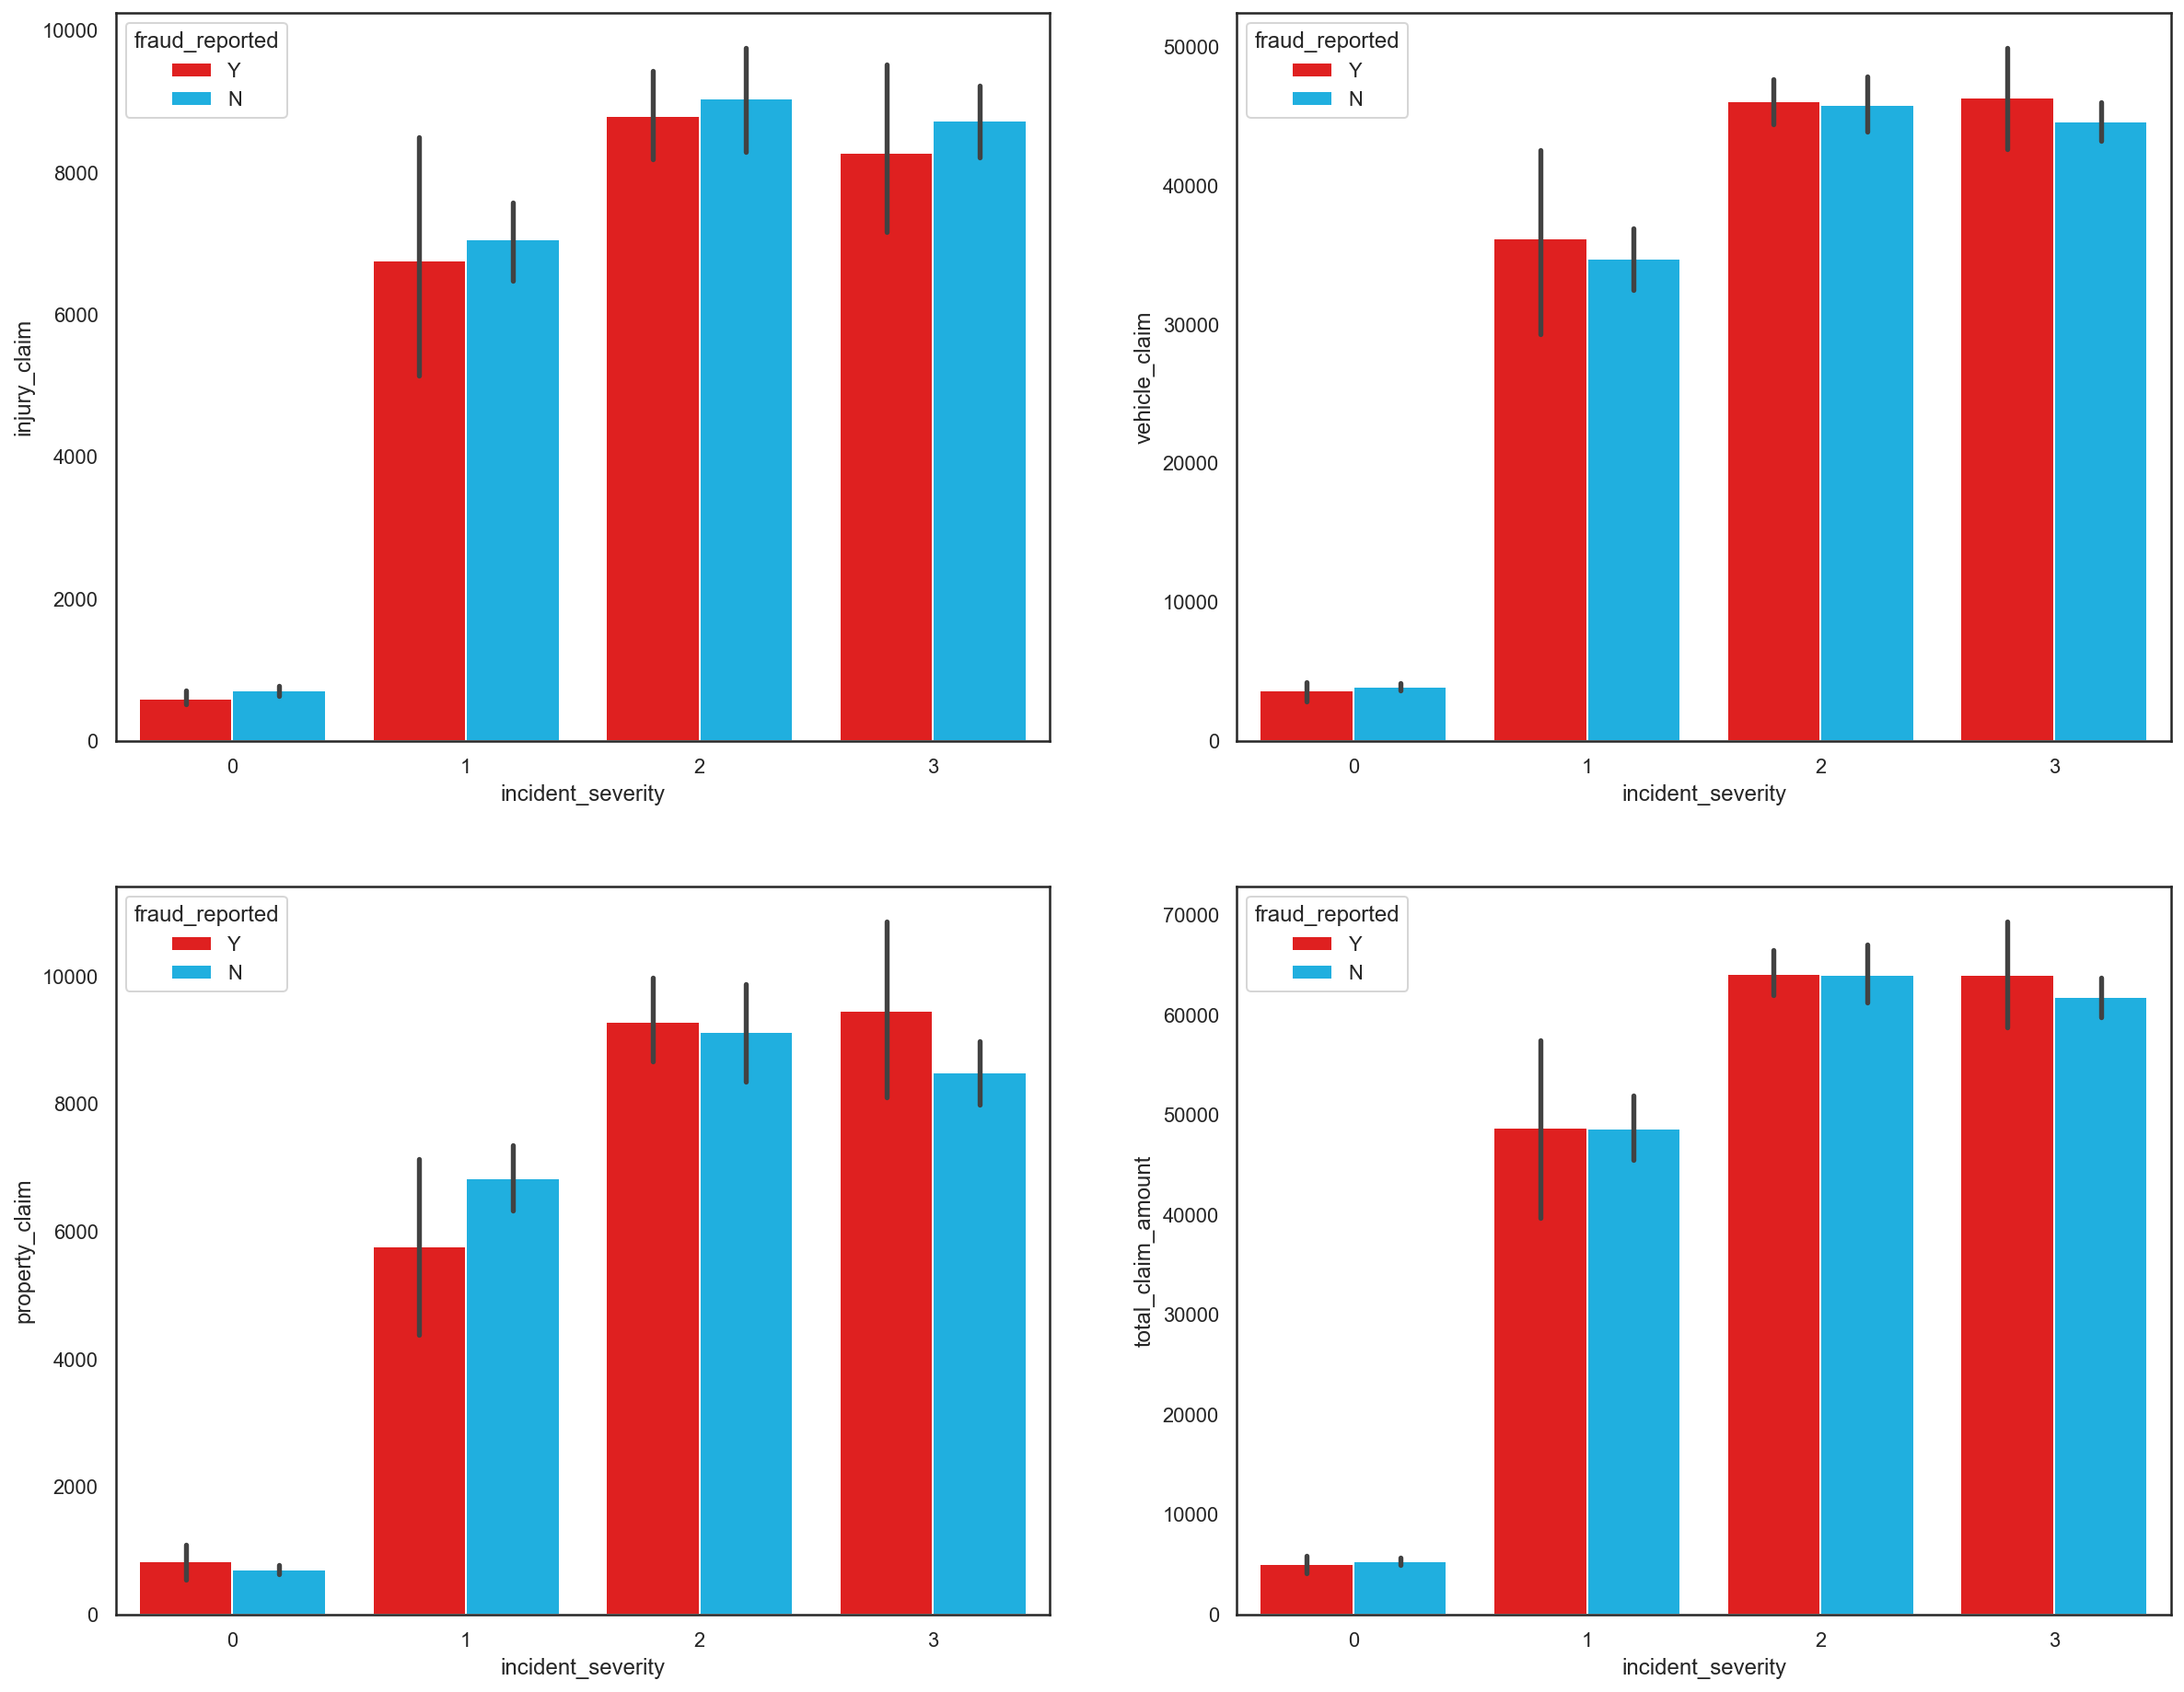

In [45]:
#severity and claims and fraud

fig, axes = plt.subplots(2,2, figsize=(20,16))

axes[0][0] = sns.barplot(x="incident_severity", y="injury_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][0]);

axes[0][1] = sns.barplot(x="incident_severity", y="vehicle_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[0][1]);

axes[1][0] = sns.barplot(x="incident_severity", y="property_claim",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][0]);

axes[1][1] = sns.barplot(x="incident_severity", y="total_claim_amount",
                hue="fraud_reported", 
                data=df, palette=['red','deepskyblue'], ax=axes[1][1]);

# vehicle claims and property claims have more frauds than injury claims
# does someone act more honestly after injury??